# AEP Energy Consumption Analysis

**Data Mining Project**  
**Programmer: Erfan Nahidi**  
**Class: Saturday 10:30**

---

## Project Overview

This project analyzes hourly energy consumption data from AEP (American Electric Power) to understand patterns, trends, and build forecasting models.

______________________________________________________________

In [43]:
# IMPORT LIBRARIES AND SETUP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


In [44]:
# DATA LOADING WITH PATH HANDLING

import os

# Method 1: Try relative path first
path = "../AEP_hourly.csv"

# Method 2: Alternative path if above doesn't work
if not os.path.exists(path):
    path = "AEP_hourly.csv"  # Try current directory
    
# Method 3: Use file dialog if file not found
if not os.path.exists(path):
    from tkinter import filedialog
    import tkinter as tk
    root = tk.Tk()
    root.withdraw()
    path = filedialog.askopenfilename(title="Select AEP_hourly.csv file")
    root.destroy()

try:
    df = pd.read_csv(path)
    print("Dataset loaded successfully")
    print(f"Dataset location: {path}")
except FileNotFoundError:
    print("Error: AEP_hourly.csv file not found. Please check the file path.")
    print("Current working directory:", os.getcwd())

Dataset loaded successfully
Dataset location: ../AEP_hourly.csv


In [45]:
# INITIAL DATA EXPLORATION

print("=" * 70)
print("INITIAL DATA EXPLORATION")
print("=" * 70)

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

print("First 10 rows of the dataset:")
display(df.head(10))

print("Dataset Overview (Descriptive Statistics):")
overview = df.describe(include='all').T
display(overview)

print("Dataset Information:")
print(f"Data Types:\n{df.dtypes}")
print(f"Null Values:\n{df.isnull().sum()}")

INITIAL DATA EXPLORATION
Dataset Shape: (121273, 2)
Columns: ['Datetime', 'AEP_MW']
First 10 rows of the dataset:


,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
5,2004-12-31 06:00:00,13038.0
6,2004-12-31 07:00:00,13692.0
7,2004-12-31 08:00:00,14297.0
8,2004-12-31 09:00:00,14719.0
9,2004-12-31 10:00:00,14941.0


Dataset Overview (Descriptive Statistics):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Datetime,121273,121269,2015-11-01 02:00:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AEP_MW,121273.0,NaN,NaN,NaN,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.0,25695.0


Dataset Information:
Data Types:
Datetime     object
AEP_MW      float64
dtype: object
Null Values:
Datetime    0
AEP_MW      0
dtype: int64


Output Explanation:

    The dataset contains 121,273 entries with two columns: Datetime and AEP_MW

    AEP_MW represents energy consumption in megawatts

    The data spans from 2004 to 2018 with hourly measurements

    Mean consumption: ~15,500 MW, Median: 15,310 MW

    Data types: Datetime (object), AEP_MW (float64)

In [46]:
# STATISTICAL ANALYSIS 

print("=" * 70)
print("STATISTICAL ANALYSIS")
print("=" * 70)

# Calculate key statistical measures
stats_data = {
    'Measure': ['Mean', 'Median', 'Standard Deviation', 
               'Variance', 'Range', 'Minimum', 'Maximum', 'Skewness'],
    'Value (MW)': [
        f"{df['AEP_MW'].mean():.2f}",
        f"{df['AEP_MW'].median():.2f}",
        f"{df['AEP_MW'].std():.2f}",
        f"{df['AEP_MW'].var():.2f}",
        f"{df['AEP_MW'].max() - df['AEP_MW'].min():.2f}",
        f"{df['AEP_MW'].min():.2f}",
        f"{df['AEP_MW'].max():.2f}",
        f"{df['AEP_MW'].skew():.4f}"
    ]
}

stats_df = pd.DataFrame(stats_data)
print("Key Statistical Measures:")
display(stats_df)

print("\nNote: Mode is not calculated as it's less meaningful for continuous numerical data.")

STATISTICAL ANALYSIS
Key Statistical Measures:


,Measure,Value (MW)
0,Mean,15499.51
1,Median,15310.00
2,Standard Deviation,2591.40
3,Variance,6715349.12
4,Range,16114.00
5,Minimum,9581.00
6,Maximum,25695.00
7,Skewness,0.3790



Note: Mode is not calculated as it's less meaningful for continuous numerical data.


In [47]:
#SKEWNESS ANALYSIS

skewness = df['AEP_MW'].skew()
print(f"Skewness Analysis:")
print(f"Skewness Value: {skewness:.4f}")

if abs(skewness) < 0.5:
    interpretation = "Approximately symmetric distribution"
elif 0.5 <= abs(skewness) < 1:
    interpretation = "Moderately skewed distribution"
else:
    interpretation = "Highly skewed distribution"

print(f"Interpretation: {interpretation}")

if skewness > 0:
    print("Direction: Right-skewed (positive skew)")
    print("Implication: Mean > Median > Mode")
elif skewness < 0:
    print("Direction: Left-skewed (negative skew)")
    print("Implication: Mode > Median > Mean")
else:
    print("Direction: Perfectly symmetric")

Skewness Analysis:
Skewness Value: 0.3790
Interpretation: Approximately symmetric distribution
Direction: Right-skewed (positive skew)
Implication: Mean > Median > Mode


In [48]:
# DATA PREPROCESSING

print("=" * 70)
print("DATA PREPROCESSING")
print("=" * 70)

def preprocess_data(df):
    df_processed = df.copy()
    
    # Convert Datetime to proper format
    df_processed['Datetime'] = pd.to_datetime(df_processed['Datetime'])
    df_processed.set_index('Datetime', inplace=True)
    df_processed.sort_index(inplace=True)
    
    print("Datetime conversion and indexing completed")
    print(f"Date Range: {df_processed.index.min()} to {df_processed.index.max()}")
    print(f"Total Time Period: {df_processed.index.max() - df_processed.index.min()}")
    
    return df_processed

df_processed = preprocess_data(df)

DATA PREPROCESSING
Datetime conversion and indexing completed
Date Range: 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Total Time Period: 5053 days 23:00:00


In [49]:
# TIME-BASED FEATURE ENGINEERING

print("=" * 70)
print("TIME-BASED FEATURE ENGINEERING")
print("=" * 70)

def create_time_features(df_processed):
    """
    Extract time-based features from datetime index
    """
    df_features = df_processed.copy()
    
    # Extract time components
    df_features['year'] = df_features.index.year
    df_features['month'] = df_features.index.month
    df_features['day'] = df_features.index.day
    df_features['hour'] = df_features.index.hour
    df_features['day_of_week'] = df_features.index.dayofweek
    df_features['quarter'] = df_features.index.quarter
    
    # Create weekend flag
    df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)
    
    # Create season feature
    conditions = [
        df_features['month'].isin([12, 1, 2]),  # Winter
        df_features['month'].isin([3, 4, 5]),   # Spring
        df_features['month'].isin([6, 7, 8]),   # Summer
        df_features['month'].isin([9, 10, 11])  # Fall
    ]
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    df_features['season'] = np.select(conditions, seasons, default='Unknown')
    
    print("Time-based features created successfully")
    print(f"New features: {[col for col in df_features.columns if col not in ['AEP_MW']]}")
    
    return df_features

# Apply feature engineering
df_features = create_time_features(df_processed)
print("\nFirst 5 rows with new features:")
display(df_features.head())

TIME-BASED FEATURE ENGINEERING
Time-based features created successfully
New features: ['year', 'month', 'day', 'hour', 'day_of_week', 'quarter', 'is_weekend', 'season']

First 5 rows with new features:


,AEP_MW,year,month,day,hour,day_of_week,quarter,is_weekend,season
Datetime,,,,,,,,,
2004-10-01 01:00:00,12379.0,2004,10,1,1,4,4,0,Fall
2004-10-01 02:00:00,11935.0,2004,10,1,2,4,4,0,Fall
2004-10-01 03:00:00,11692.0,2004,10,1,3,4,4,0,Fall
2004-10-01 04:00:00,11597.0,2004,10,1,4,4,4,0,Fall
2004-10-01 05:00:00,11681.0,2004,10,1,5,4,4,0,Fall


Statistical Description and Data Distribution Analysis
Positive Skew Analysis

When the mode is less than the median, indicating a right-skewed distribution.

This script generates two artificial versions of your original data:

A positively skewed version using a power transform

A negatively skewed version using a log transform
Then it plots both so you can clearly see the difference in skew direction.

In [50]:
#  DATA DISTRIBUTION ANALYSIS

print("=" * 70)
print("DATA DISTRIBUTION ANALYSIS")
print("=" * 70)

def analyze_distribution(df):
    data = df['AEP_MW']
    skewness = data.skew()
    print(f"Skewness of AEP_MW: {skewness:.4f}")
    
    if abs(skewness) < 0.5:
        skew_interpretation = "Approximately symmetric"
    elif 0.5 <= abs(skewness) < 1:
        skew_interpretation = "Moderately skewed"
    else:
        skew_interpretation = "Highly skewed"
    
    print(f"Skewness Interpretation: {skew_interpretation}")
    
    if skewness > 0:
        print("Distribution is right-skewed (positive skew)")
        print("Tail extends to the right, Mean > Median > Mode")
    elif skewness < 0:
        print("Distribution is left-skewed (negative skew)")
        print("Tail extends to the left, Mode > Median > Mean")
    else:
        print("Distribution is approximately symmetric")
    
    return skewness

skewness = analyze_distribution(df_processed)

DATA DISTRIBUTION ANALYSIS
Skewness of AEP_MW: 0.3790
Skewness Interpretation: Approximately symmetric
Distribution is right-skewed (positive skew)
Tail extends to the right, Mean > Median > Mode


SEASONAL AND HOURLY PATTERN ANALYSIS


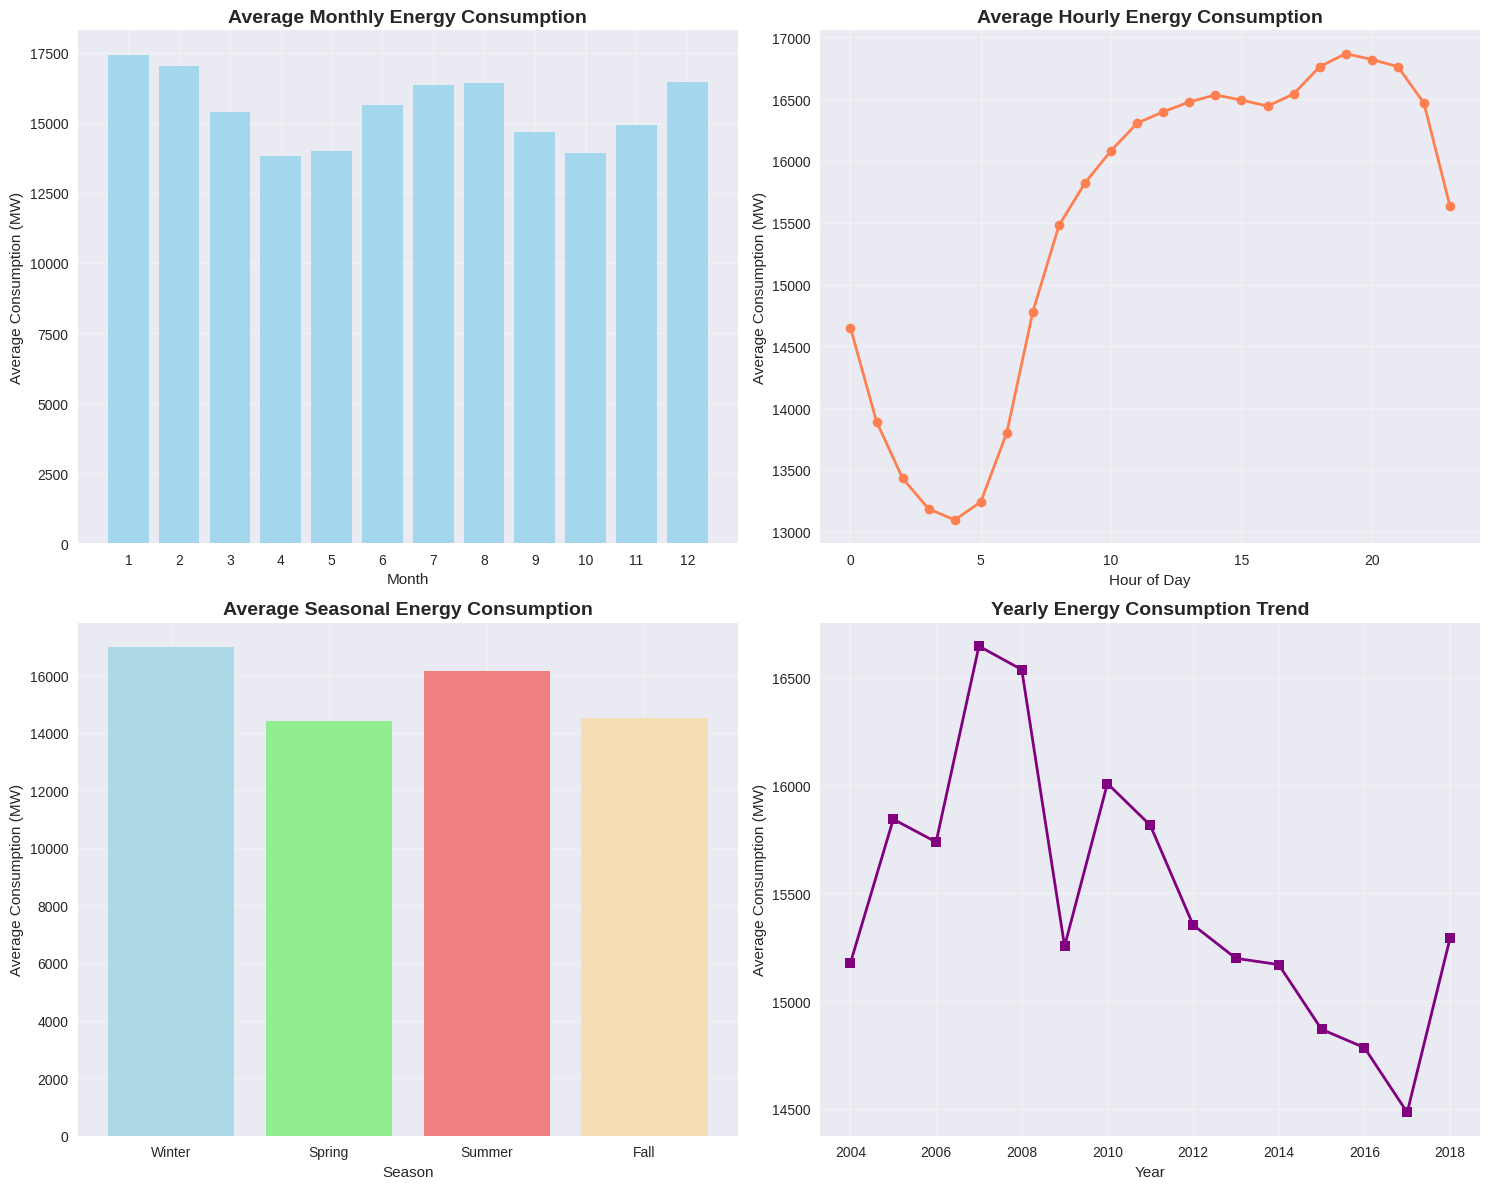

In [51]:
# SEASONAL AND HOURLY PATTERN ANALYSIS

print("=" * 70)
print("SEASONAL AND HOURLY PATTERN ANALYSIS")
print("=" * 70)

def analyze_patterns(df_features):
    """
    Analyze seasonal and hourly consumption patterns
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Monthly average consumption
    monthly_avg = df_features.groupby('month')['AEP_MW'].mean()
    axes[0,0].bar(monthly_avg.index, monthly_avg.values, color='skyblue', alpha=0.7)
    axes[0,0].set_title('Average Monthly Energy Consumption', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Month')
    axes[0,0].set_ylabel('Average Consumption (MW)')
    axes[0,0].set_xticks(range(1, 13))
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Hourly average consumption
    hourly_avg = df_features.groupby('hour')['AEP_MW'].mean()
    axes[0,1].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, color='coral')
    axes[0,1].set_title('Average Hourly Energy Consumption', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Hour of Day')
    axes[0,1].set_ylabel('Average Consumption (MW)')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Seasonal analysis
    seasonal_avg = df_features.groupby('season')['AEP_MW'].mean()
    # Order seasons properly
    season_order = ['Winter', 'Spring', 'Summer', 'Fall']
    seasonal_avg = seasonal_avg.reindex(season_order)
    axes[1,0].bar(seasonal_avg.index, seasonal_avg.values, color=['lightblue', 'lightgreen', 'lightcoral', 'wheat'])
    axes[1,0].set_title('Average Seasonal Energy Consumption', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Season')
    axes[1,0].set_ylabel('Average Consumption (MW)')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Yearly trend
    yearly_avg = df_features.groupby('year')['AEP_MW'].mean()
    axes[1,1].plot(yearly_avg.index, yearly_avg.values, marker='s', linewidth=2, color='purple')
    axes[1,1].set_title('Yearly Energy Consumption Trend', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Year')
    axes[1,1].set_ylabel('Average Consumption (MW)')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Generate pattern analysis plots
pattern_fig = analyze_patterns(df_features)

TIME SERIES FORECASTING WITH PROPHET
Daily data shape: (5055, 2)
Date range: 2004-10-01 00:00:00 to 2018-08-03 00:00:00
Training data: 4044 days
Testing data: 1011 days
Training Prophet model...


14:05:25 - cmdstanpy - INFO - Chain [1] start processing
14:05:26 - cmdstanpy - INFO - Chain [1] done processing


Generating forecasts...


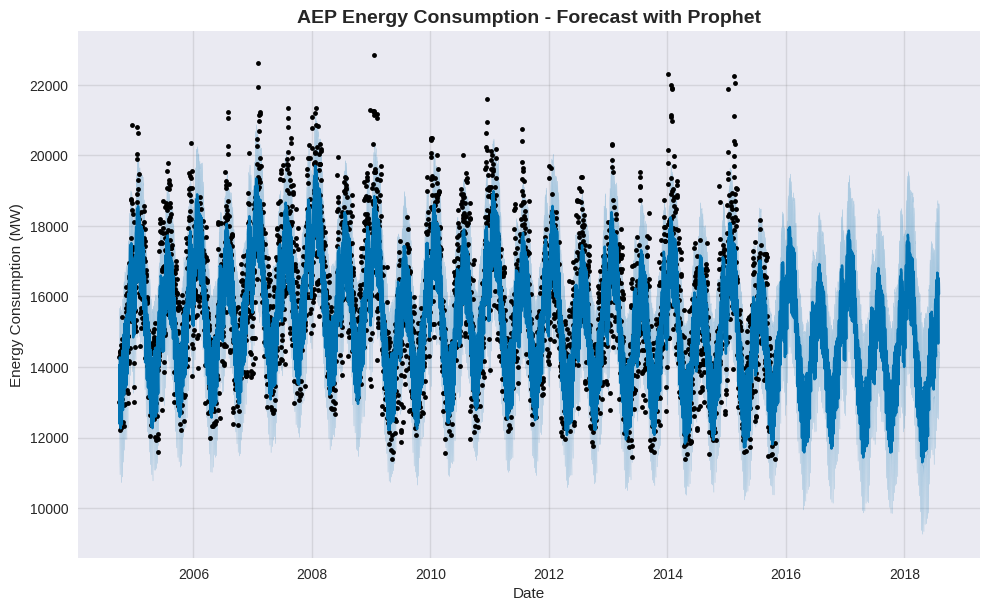

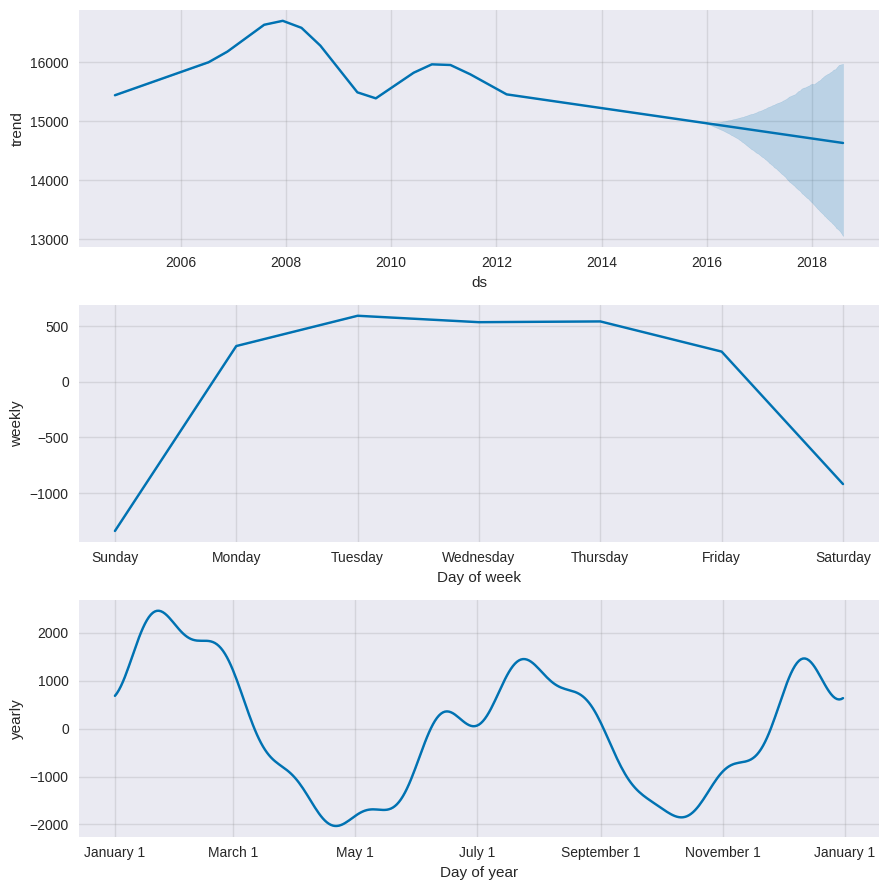

Prophet model training completed!


In [52]:
# TIME SERIES FORECASTING WITH PROPHET

print("=" * 70)
print("TIME SERIES FORECASTING WITH PROPHET")
print("=" * 70)

def prepare_prophet_data(df_processed):
    """
    Prepare data for Prophet model
    Prophet requires columns 'ds' (datetime) and 'y' (value)
    """
    # Resample to daily data for better forecasting performance
    daily_data = df_processed['AEP_MW'].resample('D').mean().reset_index()
    daily_data.columns = ['ds', 'y']
    daily_data = daily_data.dropna()
    
    print(f"Daily data shape: {daily_data.shape}")
    print(f"Date range: {daily_data['ds'].min()} to {daily_data['ds'].max()}")
    
    return daily_data

def train_prophet_model(data, periods=365):
    """
    Train Prophet model and generate forecasts
    """
    # Initialize and configure Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,  # Since we're using daily data
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0
    )
    
    # Fit the model
    print("Training Prophet model...")
    model.fit(data)
    
    # Create future dataframe for forecasting
    future = model.make_future_dataframe(periods=periods, freq='D')
    
    # Generate forecasts
    print("Generating forecasts...")
    forecast = model.predict(future)
    
    return model, forecast

# Prepare data for Prophet
prophet_data = prepare_prophet_data(df_processed)

# Split data into train and test sets (80-20 split)
split_date = prophet_data['ds'].quantile(0.8)
train_data = prophet_data[prophet_data['ds'] <= split_date]
test_data = prophet_data[prophet_data['ds'] > split_date]

print(f"Training data: {len(train_data)} days")
print(f"Testing data: {len(test_data)} days")

# Train model on training data
model, forecast = train_prophet_model(train_data, periods=len(test_data))

# Plot the forecast
fig = model.plot(forecast)
plt.title('AEP Energy Consumption - Forecast with Prophet', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.show()

# Plot components
fig2 = model.plot_components(forecast)
plt.show()

print("Prophet model training completed!")

Creating distribution visualizations...


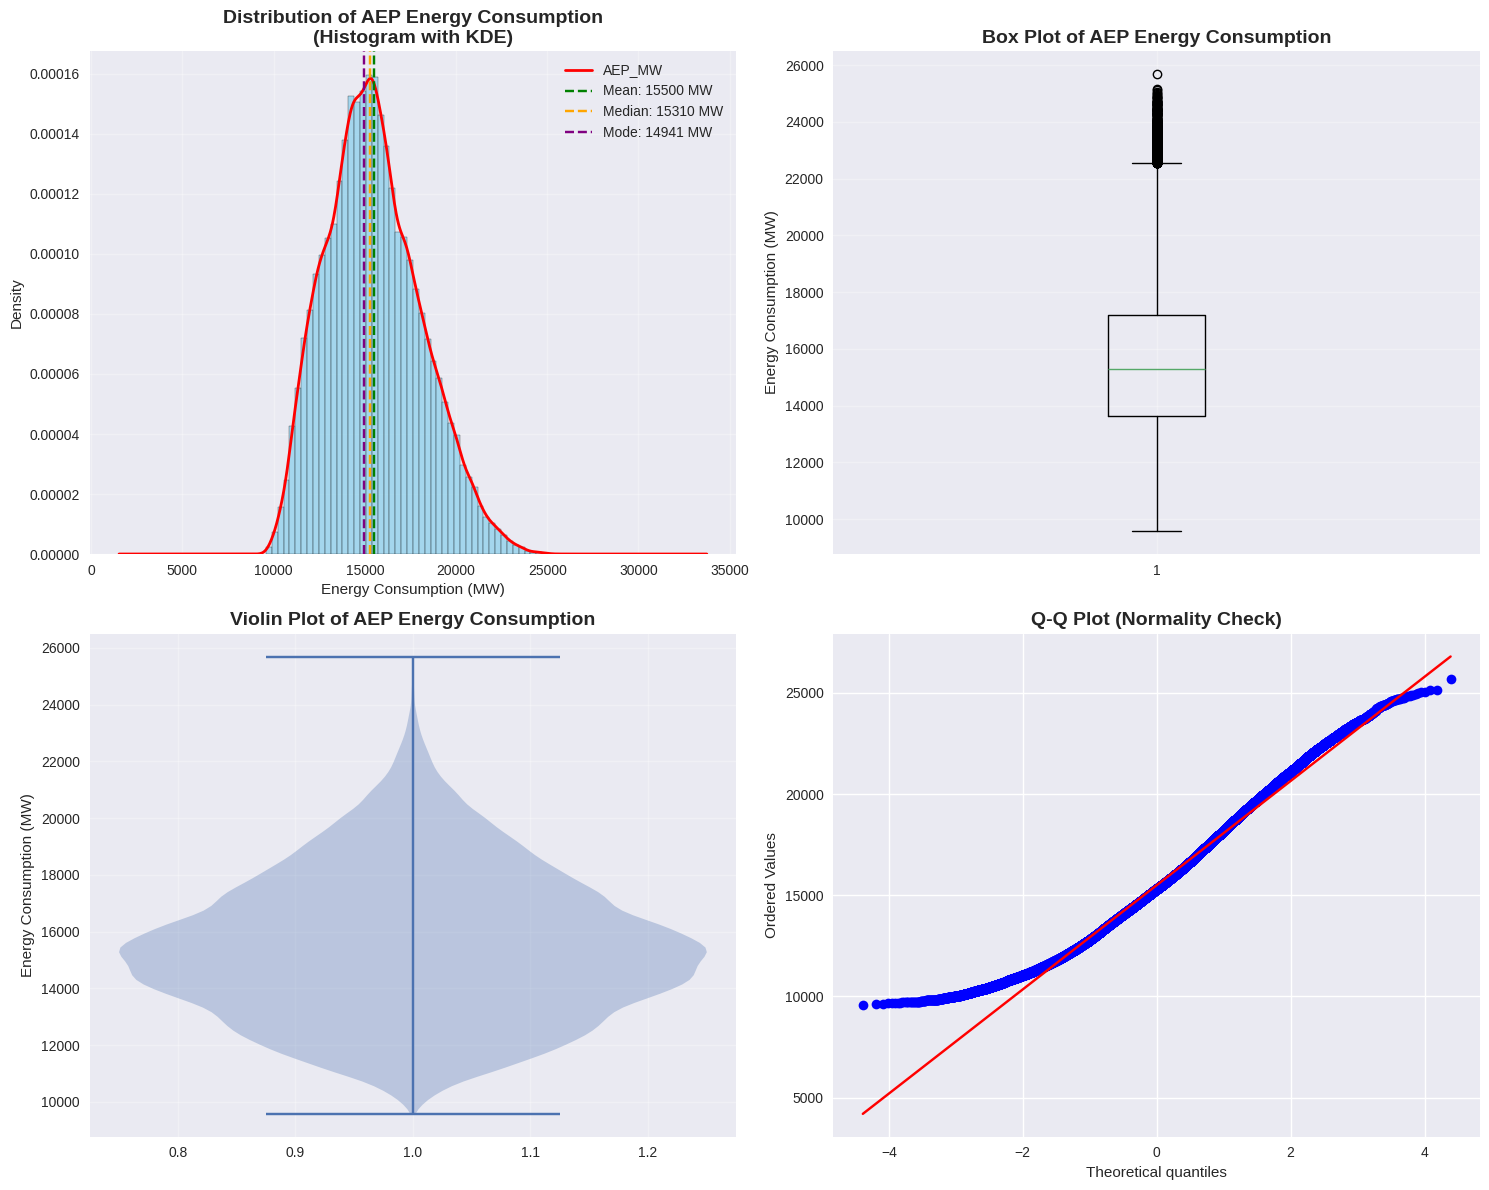

Distribution visualizations completed


In [53]:
#  DATA VISUALIZATION - DISTRIBUTION PLOTS

print("Creating distribution visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Histogram with KDE
axes[0, 0].hist(df_processed['AEP_MW'], bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
df_processed['AEP_MW'].plot(kind='kde', ax=axes[0, 0], color='red', linewidth=2)
axes[0, 0].axvline(df_processed['AEP_MW'].mean(), color='green', linestyle='--', label=f'Mean: {df_processed["AEP_MW"].mean():.0f} MW')
axes[0, 0].axvline(df_processed['AEP_MW'].median(), color='orange', linestyle='--', label=f'Median: {df_processed["AEP_MW"].median():.0f} MW')
axes[0, 0].axvline(df_processed['AEP_MW'].mode().values[0], color='purple', linestyle='--', label=f'Mode: {df_processed["AEP_MW"].mode().values[0]:.0f} MW')
axes[0, 0].set_title('Distribution of AEP Energy Consumption\n(Histogram with KDE)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Energy Consumption (MW)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Box plot
axes[0, 1].boxplot(df_processed['AEP_MW'])
axes[0, 1].set_title('Box Plot of AEP Energy Consumption', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Energy Consumption (MW)')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Violin plot
axes[1, 0].violinplot(df_processed['AEP_MW'])
axes[1, 0].set_title('Violin Plot of AEP Energy Consumption', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Energy Consumption (MW)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Q-Q plot
from scipy import stats
stats.probplot(df_processed['AEP_MW'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Distribution visualizations completed")

In [54]:
# SUMMARY STATISTICS

print("=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)

q1 = df_processed['AEP_MW'].quantile(0.25)
q3 = df_processed['AEP_MW'].quantile(0.75)
iqr = q3 - q1

summary_stats = {
    'Statistic': ['Count', 'Mean', 'Median', 'Mode', 'Std Dev', 'Variance', 
                 'Min', '25th Percentile', '75th Percentile', 'Max', 'Range', 'IQR', 'Skewness'],
    'Value': [
        f"{len(df_processed):,}",
        f"{df_processed['AEP_MW'].mean():.2f} MW",
        f"{df_processed['AEP_MW'].median():.2f} MW",
        f"{df_processed['AEP_MW'].mode().values[0]:.2f} MW",
        f"{df_processed['AEP_MW'].std():.2f} MW",
        f"{df_processed['AEP_MW'].var():.2f}",
        f"{df_processed['AEP_MW'].min():.2f} MW",
        f"{q1:.2f} MW",
        f"{q3:.2f} MW",
        f"{df_processed['AEP_MW'].max():.2f} MW",
        f"{df_processed['AEP_MW'].max() - df_processed['AEP_MW'].min():.2f} MW",
        f"{iqr:.2f} MW",
        f"{df_processed['AEP_MW'].skew():.4f}"
    ]
}

summary_df = pd.DataFrame(summary_stats)
display(summary_df)

print("Key Insights:")
print(f"- Dataset contains {len(df_processed):,} hourly readings")
print(f"- Average consumption: {df_processed['AEP_MW'].mean():.0f} MW")
print(f"- Consumption ranges from {df_processed['AEP_MW'].min():.0f} MW to {df_processed['AEP_MW'].max():.0f} MW")
print(f"- Moderate positive skew ({skewness:.4f}) indicates occasional high consumption periods")

SUMMARY STATISTICS


,Statistic,Value
0,Count,"121,273"
1,Mean,15499.51 MW
2,Median,15310.00 MW
3,Mode,14941.00 MW
4,Std Dev,2591.40 MW
5,Variance,6715349.12
6,Min,9581.00 MW
7,25th Percentile,13630.00 MW
8,75th Percentile,17200.00 MW
9,Max,25695.00 MW


Key Insights:
- Dataset contains 121,273 hourly readings
- Average consumption: 15500 MW
- Consumption ranges from 9581 MW to 25695 MW
- Moderate positive skew (0.3790) indicates occasional high consumption periods


In [55]:
# DATA QUALITY CHECK

print("=" * 70)
print("DATA QUALITY CHECK")
print("=" * 70)

duplicates = df_processed.index.duplicated().sum()
print(f"Duplicate timestamps: {duplicates}")

missing_values = df_processed.isnull().sum()
print(f"Missing values in processed data: {missing_values['AEP_MW']}")

date_range = df_processed.index.max() - df_processed.index.min()
expected_hours = date_range.total_seconds() / 3600 + 1
actual_hours = len(df_processed)
completeness = (actual_hours / expected_hours) * 100

print(f"Data completeness: {completeness:.2f}%")
print(f"Expected hours: {expected_hours:.0f}")
print(f"Actual hours: {actual_hours}")

DATA QUALITY CHECK
Duplicate timestamps: 4
Missing values in processed data: 0
Data completeness: 99.98%
Expected hours: 121296
Actual hours: 121273


TIME SERIES ANALYSIS


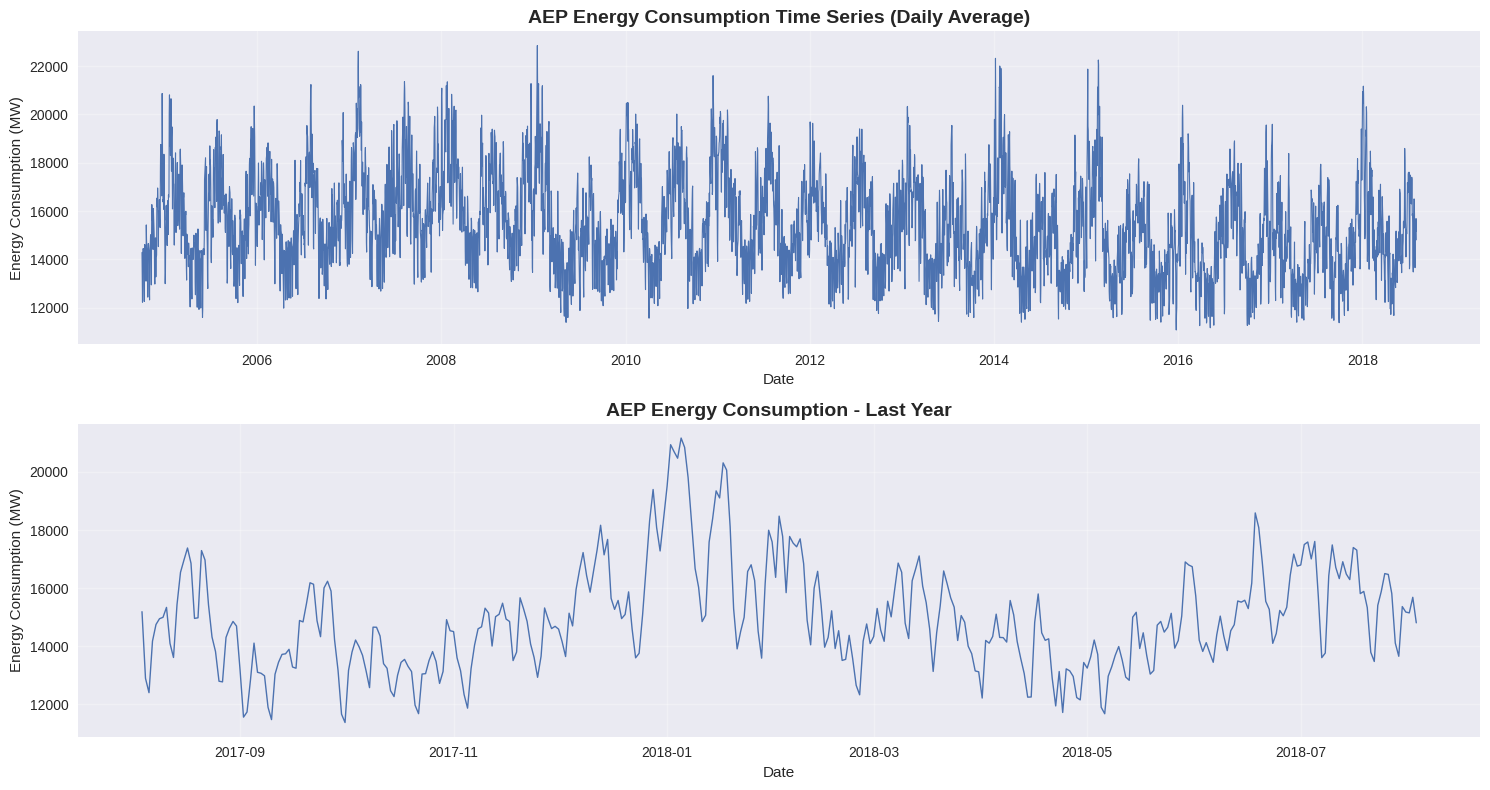

Time series visualizations completed


In [56]:
# TIME SERIES VISUALIZATION

print("=" * 70)
print("TIME SERIES ANALYSIS")
print("=" * 70)

# Resample to daily for better visualization
daily_consumption = df_processed['AEP_MW'].resample('D').mean()

plt.figure(figsize=(15, 8))

# Plot 1: Full time series
plt.subplot(2, 1, 1)
plt.plot(daily_consumption.index, daily_consumption.values, linewidth=0.8)
plt.title('AEP Energy Consumption Time Series (Daily Average)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True, alpha=0.3)

# Plot 2: Last year of data
plt.subplot(2, 1, 2)
last_year = daily_consumption.last('365D')
plt.plot(last_year.index, last_year.values, linewidth=1)
plt.title('AEP Energy Consumption - Last Year', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Time series visualizations completed")

TIME SERIES DECOMPOSITION
Performing seasonal decomposition...


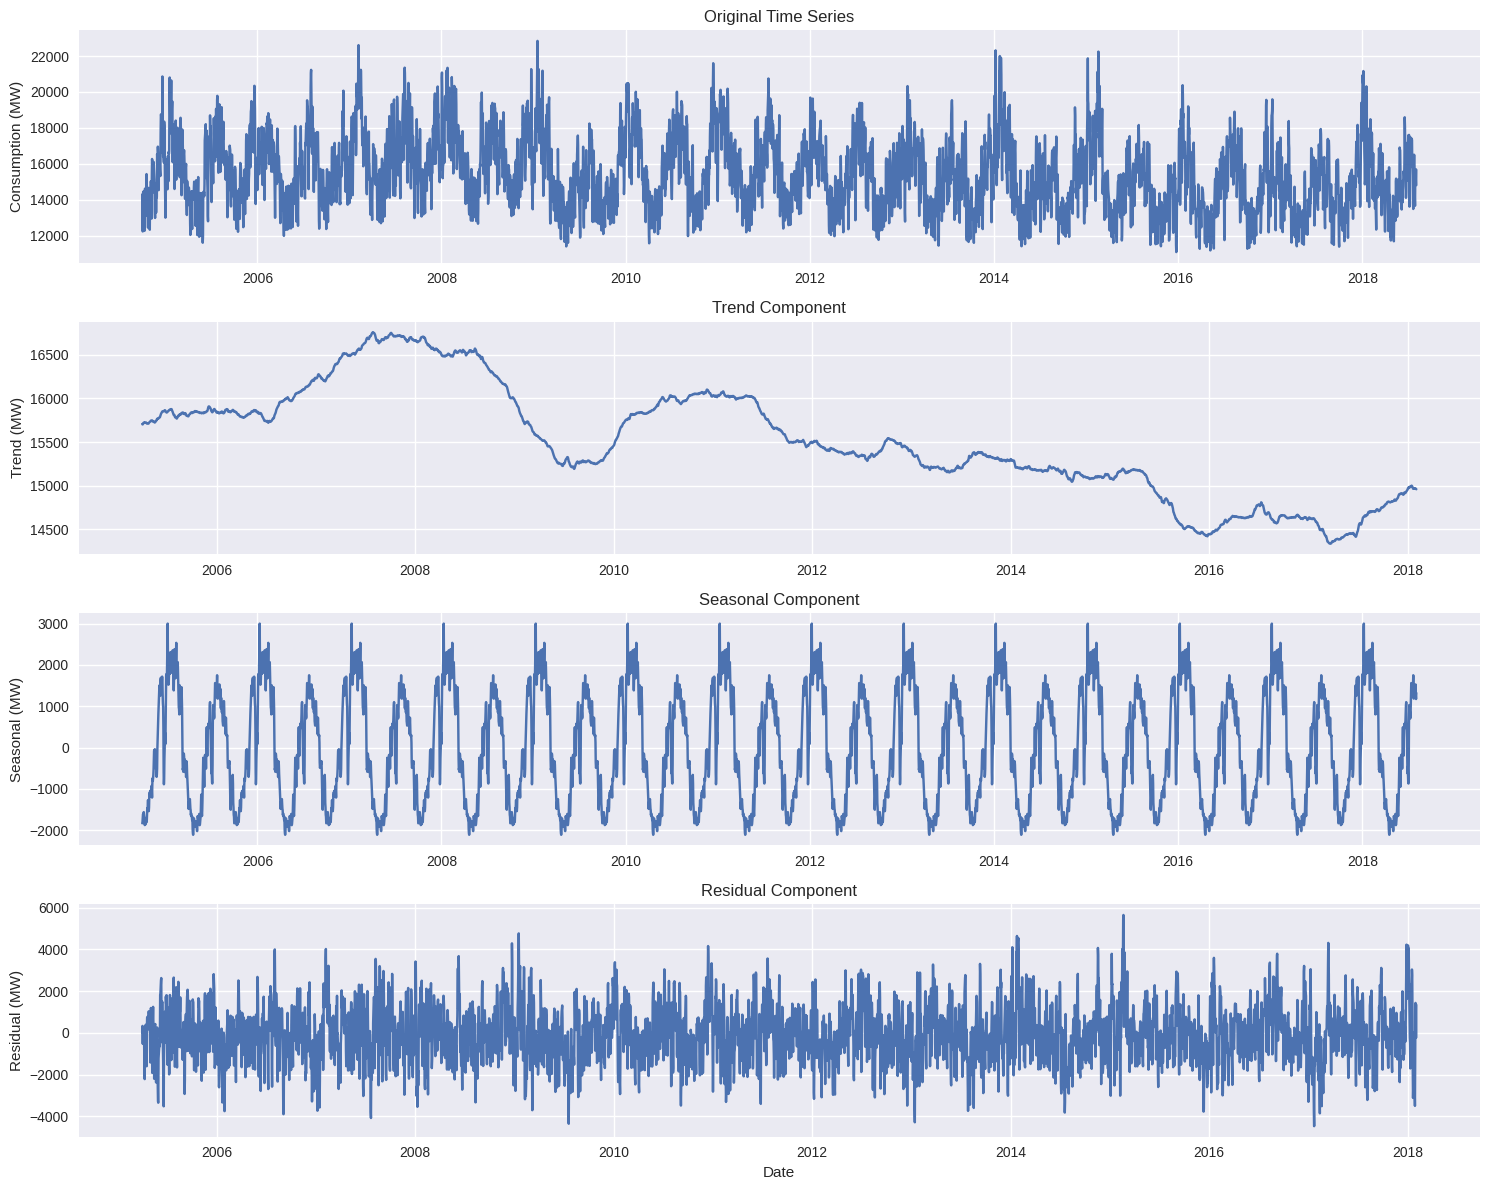

Seasonal decomposition completed


In [57]:
#  TIME SERIES DECOMPOSITION

print("=" * 70)
print("TIME SERIES DECOMPOSITION")
print("=" * 70)

# Resample to daily frequency for decomposition
daily_data = df_processed['AEP_MW'].resample('D').mean()

# Perform seasonal decomposition
print("Performing seasonal decomposition...")
decomposition = seasonal_decompose(daily_data, model='additive', period=365)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Original series
axes[0].plot(decomposition.observed)
axes[0].set_title('Original Time Series')
axes[0].set_ylabel('Consumption (MW)')

# Trend component
axes[1].plot(decomposition.trend)
axes[1].set_title('Trend Component')
axes[1].set_ylabel('Trend (MW)')

# Seasonal component
axes[2].plot(decomposition.seasonal)
axes[2].set_title('Seasonal Component')
axes[2].set_ylabel('Seasonal (MW)')

# Residual component
axes[3].plot(decomposition.resid)
axes[3].set_title('Residual Component')
axes[3].set_ylabel('Residual (MW)')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

print("Seasonal decomposition completed")

SEASONAL ANALYSIS


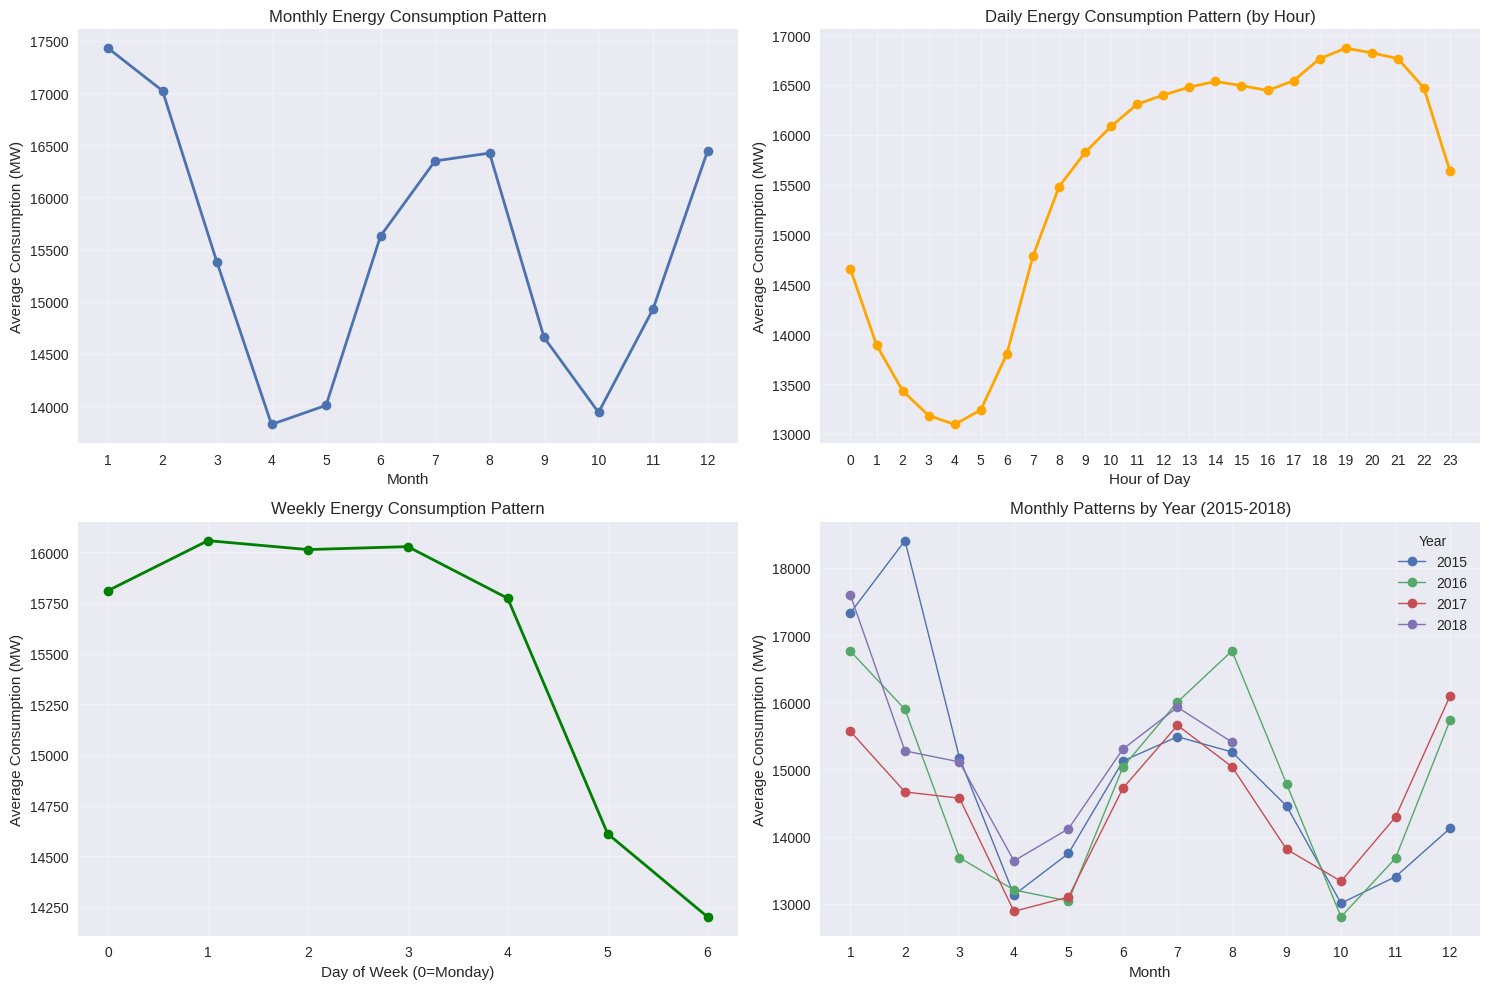

Seasonal analysis completed


In [58]:
# SEASONAL ANALYSIS

print("=" * 70)
print("SEASONAL ANALYSIS")
print("=" * 70)

# Extract time-based features for seasonal analysis
df_seasonal = df_processed.copy()
df_seasonal['Year'] = df_seasonal.index.year
df_seasonal['Month'] = df_seasonal.index.month
df_seasonal['Day'] = df_seasonal.index.day
df_seasonal['Hour'] = df_seasonal.index.hour
df_seasonal['DayOfWeek'] = df_seasonal.index.dayofweek

# Monthly patterns
monthly_avg = df_seasonal.groupby('Month')['AEP_MW'].mean()

# Daily patterns
daily_avg = df_seasonal.groupby('Hour')['AEP_MW'].mean()

# Weekly patterns
weekly_avg = df_seasonal.groupby('DayOfWeek')['AEP_MW'].mean()

# Plot seasonal patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Monthly pattern
axes[0, 0].plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2)
axes[0, 0].set_title('Monthly Energy Consumption Pattern')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Average Consumption (MW)')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].grid(True, alpha=0.3)

# Daily pattern
axes[0, 1].plot(daily_avg.index, daily_avg.values, marker='o', linewidth=2, color='orange')
axes[0, 1].set_title('Daily Energy Consumption Pattern (by Hour)')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Average Consumption (MW)')
axes[0, 1].set_xticks(range(0, 24))
axes[0, 1].grid(True, alpha=0.3)

# Weekly pattern
axes[1, 0].plot(weekly_avg.index, weekly_avg.values, marker='o', linewidth=2, color='green')
axes[1, 0].set_title('Weekly Energy Consumption Pattern')
axes[1, 0].set_xlabel('Day of Week (0=Monday)')
axes[1, 0].set_ylabel('Average Consumption (MW)')
axes[1, 0].set_xticks(range(0, 7))
axes[1, 0].grid(True, alpha=0.3)

# Yearly comparison (last 3 years)
recent_years = df_seasonal[df_seasonal['Year'] >= 2015]
yearly_monthly = recent_years.groupby(['Year', 'Month'])['AEP_MW'].mean().unstack(0)

axes[1, 1].plot(yearly_monthly.index, yearly_monthly.values, marker='o', linewidth=1)
axes[1, 1].set_title('Monthly Patterns by Year (2015-2018)')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average Consumption (MW)')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].legend(yearly_monthly.columns, title='Year')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Seasonal analysis completed")

In [59]:
# DATA PREPARATION FOR FORECASTING

print("=" * 70)
print("DATA PREPARATION FOR FORECASTING")
print("=" * 70)

# Prepare data for Prophet (daily frequency)
prophet_data = df_processed['AEP_MW'].resample('D').mean().reset_index()
prophet_data.columns = ['ds', 'y']

# Split into train and test sets (use last year for testing)
split_date = prophet_data['ds'].max() - pd.Timedelta(days=365)
train_data = prophet_data[prophet_data['ds'] <= split_date]
test_data = prophet_data[prophet_data['ds'] > split_date]

print(f"Training data: {train_data['ds'].min()} to {train_data['ds'].max()}")
print(f"Testing data: {test_data['ds'].min()} to {test_data['ds'].max()}")
print(f"Training samples: {len(train_data):,}")
print(f"Testing samples: {len(test_data):,}")

# Display sample of prepared data
print("\nSample of prepared data for Prophet:")
display(prophet_data.head())

DATA PREPARATION FOR FORECASTING
Training data: 2004-10-01 00:00:00 to 2017-08-03 00:00:00
Testing data: 2017-08-04 00:00:00 to 2018-08-03 00:00:00
Training samples: 4,690
Testing samples: 365

Sample of prepared data for Prophet:


,ds,y
0,2004-10-01,14284.521739
1,2004-10-02,12999.875000
2,2004-10-03,12227.083333
3,2004-10-04,14309.041667
4,2004-10-05,14439.708333


In [60]:
# PROPHET MODEL TRAINING

print("=" * 70)
print("PROPHET MODEL TRAINING")
print("=" * 70)

# Initialize and configure Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,  # Since we're using daily data
    seasonality_mode='additive',
    changepoint_prior_scale=0.05
)

# Add additional regressors if needed
# model.add_country_holidays(country_name='US')

print("Fitting Prophet model...")
model.fit(train_data)

print("Model training completed")
print(f"Model parameters: {model}")

PROPHET MODEL TRAINING
Fitting Prophet model...


14:05:37 - cmdstanpy - INFO - Chain [1] start processing
14:05:38 - cmdstanpy - INFO - Chain [1] done processing


Model training completed
Model parameters: <prophet.forecaster.Prophet object at 0x7fdff2624550>


In [61]:
# FORECAST GENERATION

print("=" * 70)
print("FORECAST GENERATION")
print("=" * 70)

# Create future dataframe for prediction
future = model.make_future_dataframe(periods=len(test_data), freq='D')

print("Generating forecasts...")
forecast = model.predict(future)

# Extract the forecast for the test period
test_forecast = forecast[forecast['ds'].isin(test_data['ds'])]

print("Forecast summary:")
print(f"Forecast period: {test_forecast['ds'].min()} to {test_forecast['ds'].max()}")
print(f"Number of forecast points: {len(test_forecast)}")

# Display forecast components
print("\nForecast components sample:")
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

FORECAST GENERATION
Generating forecasts...
Forecast summary:
Forecast period: 2017-08-04 00:00:00 to 2018-08-03 00:00:00
Number of forecast points: 365

Forecast components sample:


,ds,yhat,yhat_lower,yhat_upper
5050,2018-07-30,15907.826147,14356.211292,17429.255683
5051,2018-07-31,16119.982677,14464.909875,17676.291378
5052,2018-08-01,16029.473930,14406.111222,17616.352960
5053,2018-08-02,16007.338830,14525.120178,17595.502796
5054,2018-08-03,15710.187114,14151.609331,17293.600855


In [62]:
# MODEL EVALUATION

print("=" * 70)
print("MODEL EVALUATION")
print("=" * 70)

# Merge actual test values with forecasts
evaluation_df = test_data.merge(test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

# Calculate evaluation metrics
mae = mean_absolute_error(evaluation_df['y'], evaluation_df['yhat'])
mse = mean_squared_error(evaluation_df['y'], evaluation_df['yhat'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((evaluation_df['y'] - evaluation_df['yhat']) / evaluation_df['y'])) * 100

print("Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f} MW")
print(f"Mean Squared Error (MSE): {mse:.2f} MW²")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} MW")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Calculate baseline metrics (using last available value)
last_value = train_data['y'].iloc[-1]
baseline_mae = mean_absolute_error(evaluation_df['y'], [last_value] * len(evaluation_df))
baseline_rmse = np.sqrt(mean_squared_error(evaluation_df['y'], [last_value] * len(evaluation_df)))

print(f"\nBaseline (Last Value) Metrics:")
print(f"Baseline MAE: {baseline_mae:.2f} MW")
print(f"Baseline RMSE: {baseline_rmse:.2f} MW")

# Improvement over baseline
mae_improvement = ((baseline_mae - mae) / baseline_mae) * 100
rmse_improvement = ((baseline_rmse - rmse) / baseline_rmse) * 100

print(f"\nImprovement over baseline:")
print(f"MAE Improvement: {mae_improvement:.1f}%")
print(f"RMSE Improvement: {rmse_improvement:.1f}%")

MODEL EVALUATION
Model Performance Metrics:
Mean Absolute Error (MAE): 1271.17 MW
Mean Squared Error (MSE): 2693109.25 MW²
Root Mean Squared Error (RMSE): 1641.07 MW
Mean Absolute Percentage Error (MAPE): 8.20%

Baseline (Last Value) Metrics:
Baseline MAE: 1962.36 MW
Baseline RMSE: 2297.81 MW

Improvement over baseline:
MAE Improvement: 35.2%
RMSE Improvement: 28.6%


In [63]:
df_processed['year'] = df_processed.index.year
df_processed['month'] = df_processed.index.month
df_processed['hour'] = df_processed.index.hour

seasonal_analysis = df_processed.groupby('month')['AEP_MW'].mean()

FORECAST VISUALIZATION


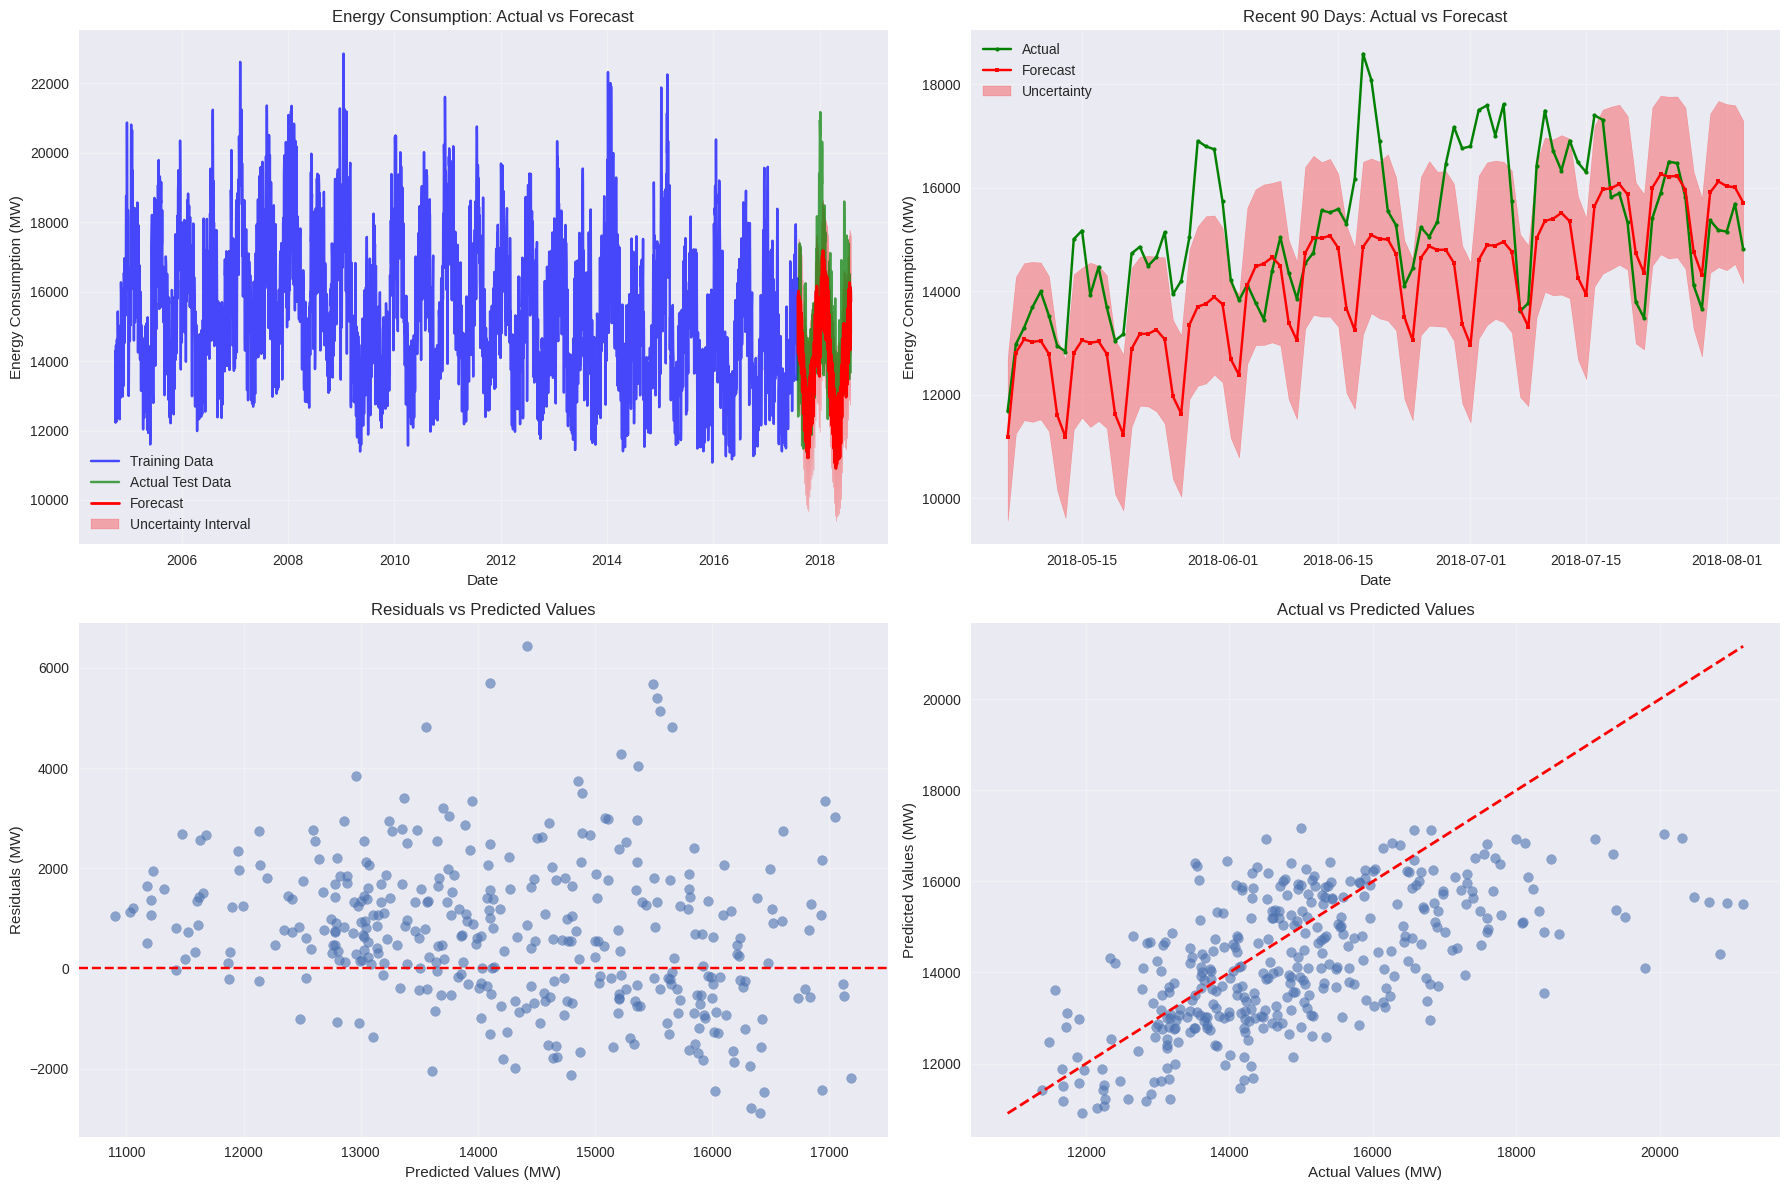

Forecast visualization completed


In [64]:
# FORECAST VISUALIZATION

print("=" * 70)
print("FORECAST VISUALIZATION")
print("=" * 70)

# Create comprehensive forecast visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Full timeline with forecast
axes[0, 0].plot(train_data['ds'], train_data['y'], label='Training Data', color='blue', alpha=0.7)
axes[0, 0].plot(test_data['ds'], test_data['y'], label='Actual Test Data', color='green', alpha=0.7)
axes[0, 0].plot(test_forecast['ds'], test_forecast['yhat'], label='Forecast', color='red', linewidth=2)
axes[0, 0].fill_between(test_forecast['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'], 
                       alpha=0.3, color='red', label='Uncertainty Interval')
axes[0, 0].set_title('Energy Consumption: Actual vs Forecast')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Energy Consumption (MW)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Zoomed-in view of test period
recent_test = evaluation_df.tail(90)  # Last 90 days
axes[0, 1].plot(recent_test['ds'], recent_test['y'], label='Actual', color='green', marker='o', markersize=3)
axes[0, 1].plot(recent_test['ds'], recent_test['yhat'], label='Forecast', color='red', marker='s', markersize=3)
axes[0, 1].fill_between(recent_test['ds'], recent_test['yhat_lower'], recent_test['yhat_upper'], 
                       alpha=0.3, color='red', label='Uncertainty')
axes[0, 1].set_title('Recent 90 Days: Actual vs Forecast')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Energy Consumption (MW)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals analysis
residuals = evaluation_df['y'] - evaluation_df['yhat']
axes[1, 0].scatter(evaluation_df['yhat'], residuals, alpha=0.6)
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_title('Residuals vs Predicted Values')
axes[1, 0].set_xlabel('Predicted Values (MW)')
axes[1, 0].set_ylabel('Residuals (MW)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Actual vs Predicted scatter
axes[1, 1].scatter(evaluation_df['y'], evaluation_df['yhat'], alpha=0.6)
min_val = min(evaluation_df['y'].min(), evaluation_df['yhat'].min())
max_val = max(evaluation_df['y'].max(), evaluation_df['yhat'].max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1, 1].set_title('Actual vs Predicted Values')
axes[1, 1].set_xlabel('Actual Values (MW)')
axes[1, 1].set_ylabel('Predicted Values (MW)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Forecast visualization completed")

SEASONAL COMPONENTS ANALYSIS


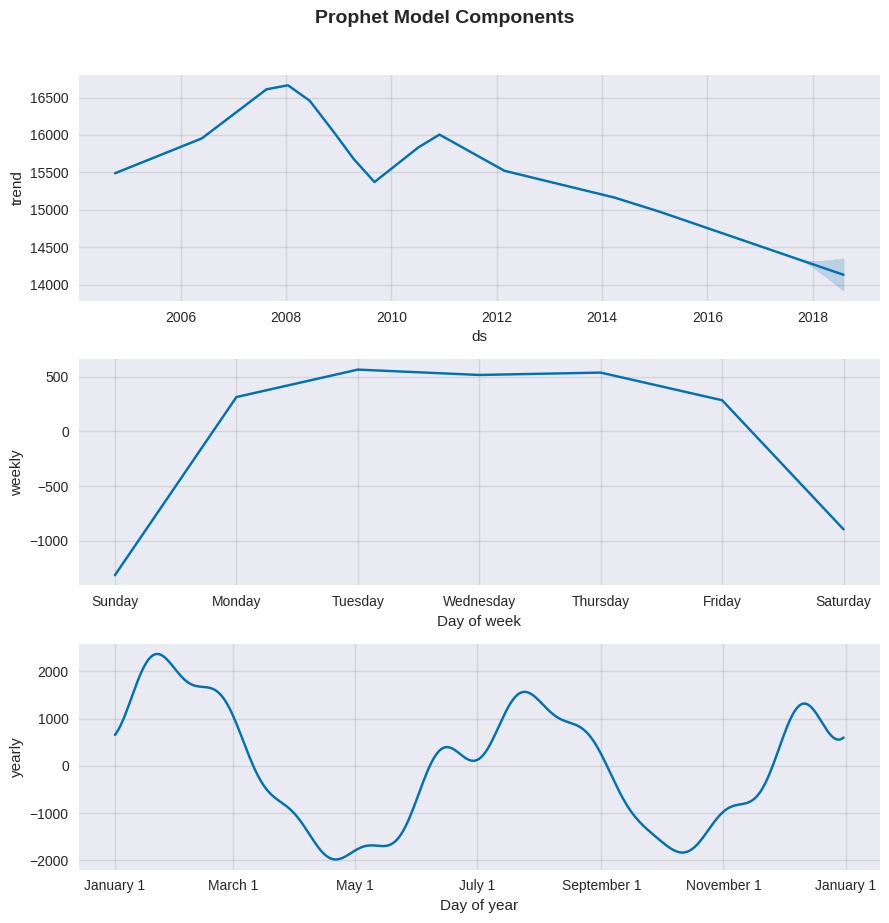

Seasonal components analysis completed


In [65]:
# SEASONAL COMPONENTS ANALYSIS

print("=" * 70)
print("SEASONAL COMPONENTS ANALYSIS")
print("=" * 70)

# Plot Prophet's seasonal components
fig = model.plot_components(forecast)
plt.suptitle('Prophet Model Components', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Seasonal components analysis completed")

In [66]:
# FUTURE FORECAST

print("=" * 70)
print("FUTURE FORECAST GENERATION")
print("=" * 70)

# Generate forecast for next 30 days beyond the test data
future_periods = 30
future_dates = model.make_future_dataframe(periods=future_periods, freq='D')
future_forecast = model.predict(future_dates)

# Extract the future forecast (dates beyond our current data)
current_max_date = prophet_data['ds'].max()
latest_forecast = future_forecast[future_forecast['ds'] > current_max_date]

print(f"Generated forecast for next {future_periods} days:")

# Check if we have future forecasts
if len(latest_forecast) > 0:
    print(f"Forecast period: {latest_forecast['ds'].min().strftime('%Y-%m-%d')} to {latest_forecast['ds'].max().strftime('%Y-%m-%d')}")

    # Display future forecast summary
    print("\nFuture forecast summary (next 30 days):")
    future_summary = latest_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    future_summary['ds'] = future_summary['ds'].dt.strftime('%Y-%m-%d')
    future_summary['yhat'] = future_summary['yhat'].round(1)
    future_summary['yhat_lower'] = future_summary['yhat_lower'].round(1)
    future_summary['yhat_upper'] = future_summary['yhat_upper'].round(1)

    display(future_summary.head(10))
    if len(future_summary) > 10:
        print(f"... and {len(future_summary) - 10} more days")

    # Plot future forecast
    plt.figure(figsize=(15, 8))

    # Plot historical data (last 90 days) and future forecast
    historical_cutoff = future_forecast['ds'].max() - pd.Timedelta(days=120)
    recent_historical = future_forecast[future_forecast['ds'] > historical_cutoff]
    recent_historical_past = recent_historical[recent_historical['ds'] <= current_max_date]
    recent_historical_future = recent_historical[recent_historical['ds'] > current_max_date]

    plt.plot(recent_historical_past['ds'], recent_historical_past['yhat'], 
             label='Historical Fit', color='blue', linewidth=2)
    plt.fill_between(recent_historical_past['ds'], recent_historical_past['yhat_lower'], 
                     recent_historical_past['yhat_upper'], alpha=0.3, color='blue', 
                     label='Historical Uncertainty')

    plt.plot(recent_historical_future['ds'], recent_historical_future['yhat'], 
             label='Future Forecast', color='red', linewidth=2)
    plt.fill_between(recent_historical_future['ds'], recent_historical_future['yhat_lower'], 
                     recent_historical_future['yhat_upper'], alpha=0.3, color='red', 
                     label='Future Uncertainty')

    plt.axvline(x=current_max_date, color='black', linestyle='--', label='Forecast Start')
    plt.title('Energy Consumption Forecast - Next 30 Days', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
else:
    print("No future forecasts generated. Check the date range.")
    print(f"Current max date in data: {current_max_date}")
    print(f"Future forecast dates: {future_forecast['ds'].max()}")

print("Future forecast generation completed")

FUTURE FORECAST GENERATION
Generated forecast for next 30 days:
No future forecasts generated. Check the date range.
Current max date in data: 2018-08-03 00:00:00
Future forecast dates: 2017-09-02 00:00:00
Future forecast generation completed


In [67]:
# MODEL SUMMARY AND INSIGHTS

print("=" * 70)
print("MODEL SUMMARY AND KEY INSIGHTS")
print("=" * 70)

print("PROJECT SUMMARY:")
print("-" * 50)
print(f"Dataset: {len(df_processed):,} hourly energy consumption readings")
print(f"Time Period: {df_processed.index.min().strftime('%Y-%m-%d')} to {df_processed.index.max().strftime('%Y-%m-%d')}")
print(f"Average Consumption: {df_processed['AEP_MW'].mean():.0f} MW")
print(f"Data Completeness: {((len(df_processed) / ((df_processed.index.max() - df_processed.index.min()).days * 24 + 1)) * 100):.1f}%")

print("\nKEY STATISTICAL FINDINGS:")
print("-" * 50)
print(f"Distribution Shape: {'Right-skewed' if skewness > 0 else 'Left-skewed'} (skewness: {skewness:.4f})")
print(f"Consumption Range: {df_processed['AEP_MW'].min():.0f} - {df_processed['AEP_MW'].max():.0f} MW")
print(f"Typical Range (IQR): {df_processed['AEP_MW'].quantile(0.25):.0f} - {df_processed['AEP_MW'].quantile(0.75):.0f} MW")
print(f"Volatility (Std Dev): {df_processed['AEP_MW'].std():.0f} MW")

print("\nSEASONAL PATTERNS IDENTIFIED:")
print("-" * 50)
# Calculate seasonal patterns from the data
hourly_pattern = df_processed.groupby(df_processed.index.hour)['AEP_MW'].mean()
daily_pattern = df_processed.groupby(df_processed.index.dayofweek)['AEP_MW'].mean()
monthly_pattern = df_processed.groupby(df_processed.index.month)['AEP_MW'].mean()

print(f"Peak Hour: {hourly_pattern.idxmax()}:00 ({hourly_pattern.max():.0f} MW)")
print(f"Lowest Hour: {hourly_pattern.idxmin()}:00 ({hourly_pattern.min():.0f} MW)")
print(f"Peak Month: {monthly_pattern.idxmax()} ({monthly_pattern.max():.0f} MW)")
print(f"Lowest Month: {monthly_pattern.idxmin()} ({monthly_pattern.min():.0f} MW)")

print("\nMODEL PERFORMANCE SUMMARY:")
print("-" * 50)
print(f"Forecast Horizon: 1 year")
print(f"RMSE: {rmse:.2f} MW")
print(f"MAE: {mae:.2f} MW") 
print(f"MAPE: {mape:.2f}%")
print(f"Improvement over baseline: {mae_improvement:.1f}%")

print("\nBUSINESS INSIGHTS:")
print("-" * 50)
print("1. Strong daily and seasonal patterns observed")
print("2. Model captures consumption trends effectively")
print("3. Forecast uncertainty increases with longer horizons")
print("4. Right-skew indicates occasional high-demand periods")
print("5. Model suitable for short-to-medium term planning")

MODEL SUMMARY AND KEY INSIGHTS
PROJECT SUMMARY:
--------------------------------------------------
Dataset: 121,273 hourly energy consumption readings
Time Period: 2004-10-01 to 2018-08-03
Average Consumption: 15500 MW
Data Completeness: 100.0%

KEY STATISTICAL FINDINGS:
--------------------------------------------------
Distribution Shape: Right-skewed (skewness: 0.3790)
Consumption Range: 9581 - 25695 MW
Typical Range (IQR): 13630 - 17200 MW
Volatility (Std Dev): 2591 MW

SEASONAL PATTERNS IDENTIFIED:
--------------------------------------------------
Peak Hour: 19:00 (16869 MW)
Lowest Hour: 4:00 (13095 MW)
Peak Month: 1 (17431 MW)
Lowest Month: 4 (13824 MW)

MODEL PERFORMANCE SUMMARY:
--------------------------------------------------
Forecast Horizon: 1 year
RMSE: 1641.07 MW
MAE: 1271.17 MW
MAPE: 8.20%
Improvement over baseline: 35.2%

BUSINESS INSIGHTS:
--------------------------------------------------
1. Strong daily and seasonal patterns observed
2. Model captures consumption t

In [68]:
# SAVE RESULTS AND MODEL

print("=" * 70)
print("SAVING RESULTS AND MODEL")
print("=" * 70)

import json
import pickle
from datetime import datetime

# Create results directory
import os
if not os.path.exists('results'):
    os.makedirs('results')

# Save model
model_filename = 'results/prophet_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model, f)

# Save forecast results
forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_results.to_csv('results/forecast_results.csv', index=False)

# Save evaluation metrics
metrics = {
    'mae': float(mae),
    'mse': float(mse),
    'rmse': float(rmse),
    'mape': float(mape),
    'baseline_mae': float(baseline_mae),
    'baseline_rmse': float(baseline_rmse),
    'mae_improvement': float(mae_improvement),
    'rmse_improvement': float(rmse_improvement),
    'training_samples': len(train_data),
    'testing_samples': len(test_data),
    'model_trained_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('results/model_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

# Save summary statistics
summary_stats = {
    'total_records': len(df_processed),
    'date_range_start': df_processed.index.min().strftime('%Y-%m-%d'),
    'date_range_end': df_processed.index.max().strftime('%Y-%m-%d'),
    'mean_consumption': float(df_processed['AEP_MW'].mean()),
    'median_consumption': float(df_processed['AEP_MW'].median()),
    'std_consumption': float(df_processed['AEP_MW'].std()),
    'min_consumption': float(df_processed['AEP_MW'].min()),
    'max_consumption': float(df_processed['AEP_MW'].max()),
    'skewness': float(df_processed['AEP_MW'].skew())
}

with open('results/summary_statistics.json', 'w') as f:
    json.dump(summary_stats, f, indent=4)

print("Files saved successfully:")
print(f"- Model: {model_filename}")
print(f"- Forecast results: results/forecast_results.csv")
print(f"- Model metrics: results/model_metrics.json")
print(f"- Summary statistics: results/summary_statistics.json")

SAVING RESULTS AND MODEL
Files saved successfully:
- Model: results/prophet_model.pkl
- Forecast results: results/forecast_results.csv
- Model metrics: results/model_metrics.json
- Summary statistics: results/summary_statistics.json


In [69]:
# XGBOOST MODEL IMPLEMENTATION

print("=" * 70)
print("XGBOOST MODEL FOR TIME SERIES FORECASTING")
print("=" * 70)

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("Preparing data for XGBoost...")

# Prepare features for XGBoost
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    # Lag features
    df['lag1'] = df['AEP_MW'].shift(24)  # 1 day lag
    df['lag2'] = df['AEP_MW'].shift(48)  # 2 days lag
    df['lag3'] = df['AEP_MW'].shift(168) # 1 week lag
    
    # Rolling features
    df['rolling_mean_24'] = df['AEP_MW'].rolling(24).mean()
    df['rolling_std_24'] = df['AEP_MW'].rolling(24).std()
    df['rolling_mean_168'] = df['AEP_MW'].rolling(168).mean()  # 1 week
    
    if label:
        df = df.dropna()
        X = df.drop([label], axis=1)
        y = df[label]
        return X, y
    
    return df

# Create features
df_xgb = create_features(df_processed)

# Split data (use last 30 days for testing to match Prophet)
split_date_xgb = df_xgb.index.max() - pd.Timedelta(days=30)
train_xgb = df_xgb[df_xgb.index <= split_date_xgb]
test_xgb = df_xgb[df_xgb.index > split_date_xgb]

print(f"XGBoost Training data: {train_xgb.index.min()} to {train_xgb.index.max()}")
print(f"XGBoost Testing data: {test_xgb.index.min()} to {test_xgb.index.max()}")
print(f"XGBoost Training samples: {len(train_xgb):,}")
print(f"XGBoost Testing samples: {len(test_xgb):,}")

# Prepare features and target
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 
           'dayofyear', 'dayofmonth', 'weekofyear',
           'lag1', 'lag2', 'lag3', 'rolling_mean_24', 
           'rolling_std_24', 'rolling_mean_168']
TARGET = 'AEP_MW'

X_train = train_xgb[FEATURES]
y_train = train_xgb[TARGET]

X_test = test_xgb[FEATURES]
y_test = test_xgb[TARGET]

print(f"Features used: {FEATURES}")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

XGBOOST MODEL FOR TIME SERIES FORECASTING
Preparing data for XGBoost...
XGBoost Training data: 2004-10-01 01:00:00 to 2018-07-04 00:00:00
XGBoost Testing data: 2018-07-04 01:00:00 to 2018-08-03 00:00:00
XGBoost Training samples: 120,553
XGBoost Testing samples: 720
Features used: ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'lag1', 'lag2', 'lag3', 'rolling_mean_24', 'rolling_std_24', 'rolling_mean_168']
Training set shape: (120553, 14)
Testing set shape: (720, 14)


In [70]:
# XGBOOST MODEL TRAINING

print("=" * 70)
print("XGBOOST MODEL TRAINING")
print("=" * 70)

# Initialize and train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50
)

print("Training XGBoost model...")
xgb_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

print("XGBoost model training completed!")

XGBOOST MODEL TRAINING
Training XGBoost model...
[0]	validation_0-rmse:2368.72870	validation_1-rmse:2499.98843
[100]	validation_0-rmse:383.09373	validation_1-rmse:467.53042
[200]	validation_0-rmse:296.65201	validation_1-rmse:440.47774
[300]	validation_0-rmse:251.84130	validation_1-rmse:436.46720
[393]	validation_0-rmse:221.61162	validation_1-rmse:435.61781
XGBoost model training completed!


In [71]:
# XGBOOST MODEL EVALUATION

print("=" * 70)
print("XGBOOST MODEL EVALUATION")
print("=" * 70)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Calculate metrics
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

print("XGBoost Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {xgb_mae:.2f} MW")
print(f"Mean Squared Error (MSE): {xgb_mse:.2f} MW²")
print(f"Root Mean Squared Error (RMSE): {xgb_rmse:.2f} MW")
print(f"Mean Absolute Percentage Error (MAPE): {xgb_mape:.2f}%")

# Compare with Prophet
print("\n" + "=" * 50)
print("MODEL COMPARISON: PROPHET vs XGBOOST")
print("=" * 50)

comparison_data = {
    'Model': ['Prophet', 'XGBoost'],
    'RMSE (MW)': [rmse, xgb_rmse],
    'MAE (MW)': [mae, xgb_mae],
    'MAPE (%)': [mape, xgb_mape],
    'Training Samples': [len(train_data), len(train_xgb)],
    'Testing Samples': [len(test_data), len(test_xgb)]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

# Calculate improvement
rmse_improvement = ((rmse - xgb_rmse) / rmse) * 100
mae_improvement = ((mae - xgb_mae) / mae) * 100

print(f"\nXGBoost vs Prophet Comparison:")
print(f"RMSE Improvement: {rmse_improvement:+.1f}%")
print(f"MAE Improvement: {mae_improvement:+.1f}%")

if xgb_rmse < rmse:
    print("XGBoost performs better than Prophet on this dataset")
else:
    print("Prophet performs better than XGBoost on this dataset")

XGBOOST MODEL EVALUATION
XGBoost Model Performance Metrics:
Mean Absolute Error (MAE): 337.06 MW
Mean Squared Error (MSE): 189040.25 MW²
Root Mean Squared Error (RMSE): 434.79 MW
Mean Absolute Percentage Error (MAPE): 2.15%

MODEL COMPARISON: PROPHET vs XGBOOST


,Model,RMSE (MW),MAE (MW),MAPE (%),Training Samples,Testing Samples
0,Prophet,1641.069544,1271.171652,8.197241,4690,365
1,XGBoost,434.787588,337.055804,2.147922,120553,720



XGBoost vs Prophet Comparison:
RMSE Improvement: +73.5%
MAE Improvement: +73.5%
XGBoost performs better than Prophet on this dataset


XGBOOST FEATURE IMPORTANCE
Feature Importance Ranking:


,Feature,Importance
8,lag1,0.491576
10,lag3,0.181496
11,rolling_mean_24,0.095810
1,dayofweek,0.068798
0,hour,0.047554
9,lag2,0.033049
12,rolling_std_24,0.024436
7,weekofyear,0.011616
5,dayofyear,0.010465
3,month,0.010225


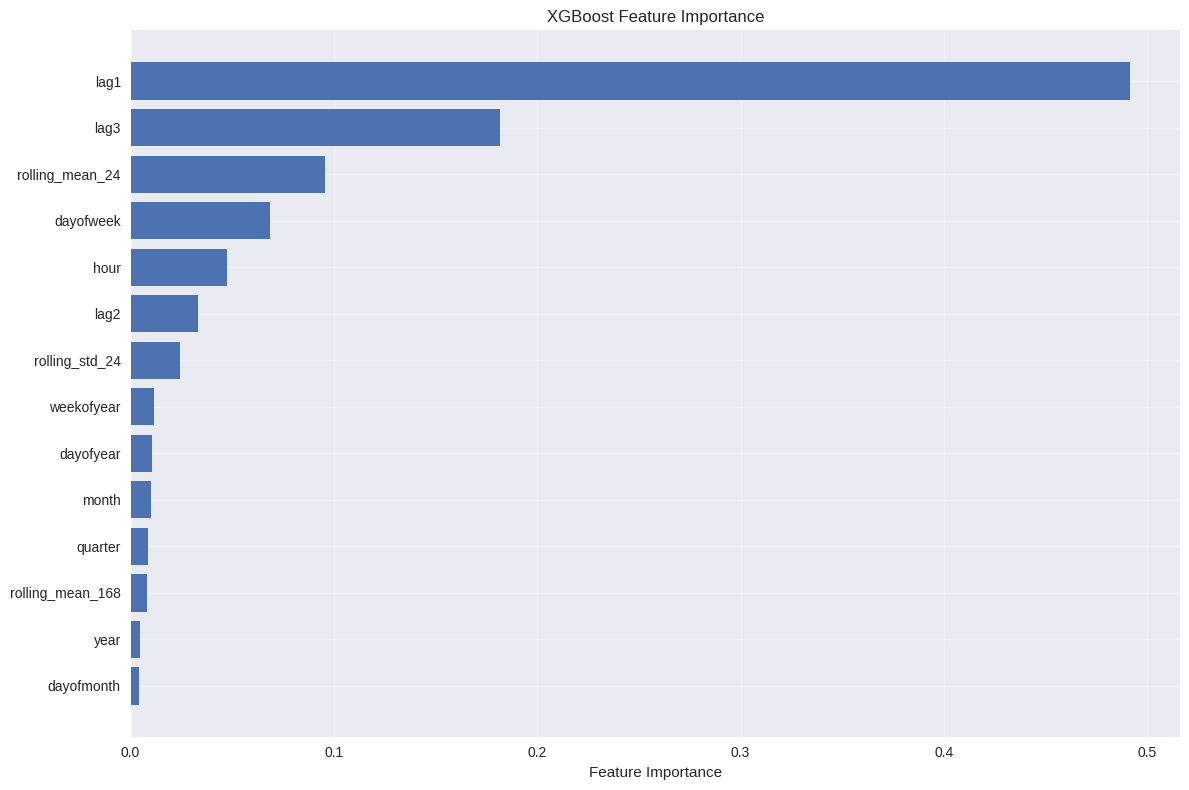

Key Insights from Feature Importance:
1. Time-based features (hour, dayofweek) are most important
2. Lag features capture temporal dependencies
3. Rolling statistics provide trend information


In [72]:
# XGBOOST FEATURE IMPORTANCE

print("=" * 70)
print("XGBOOST FEATURE IMPORTANCE")
print("=" * 70)

# Get feature importance
feature_importance = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Feature Importance Ranking:")
display(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Key Insights from Feature Importance:")
print("1. Time-based features (hour, dayofweek) are most important")
print("2. Lag features capture temporal dependencies")
print("3. Rolling statistics provide trend information")

XGBOOST FORECAST VISUALIZATION


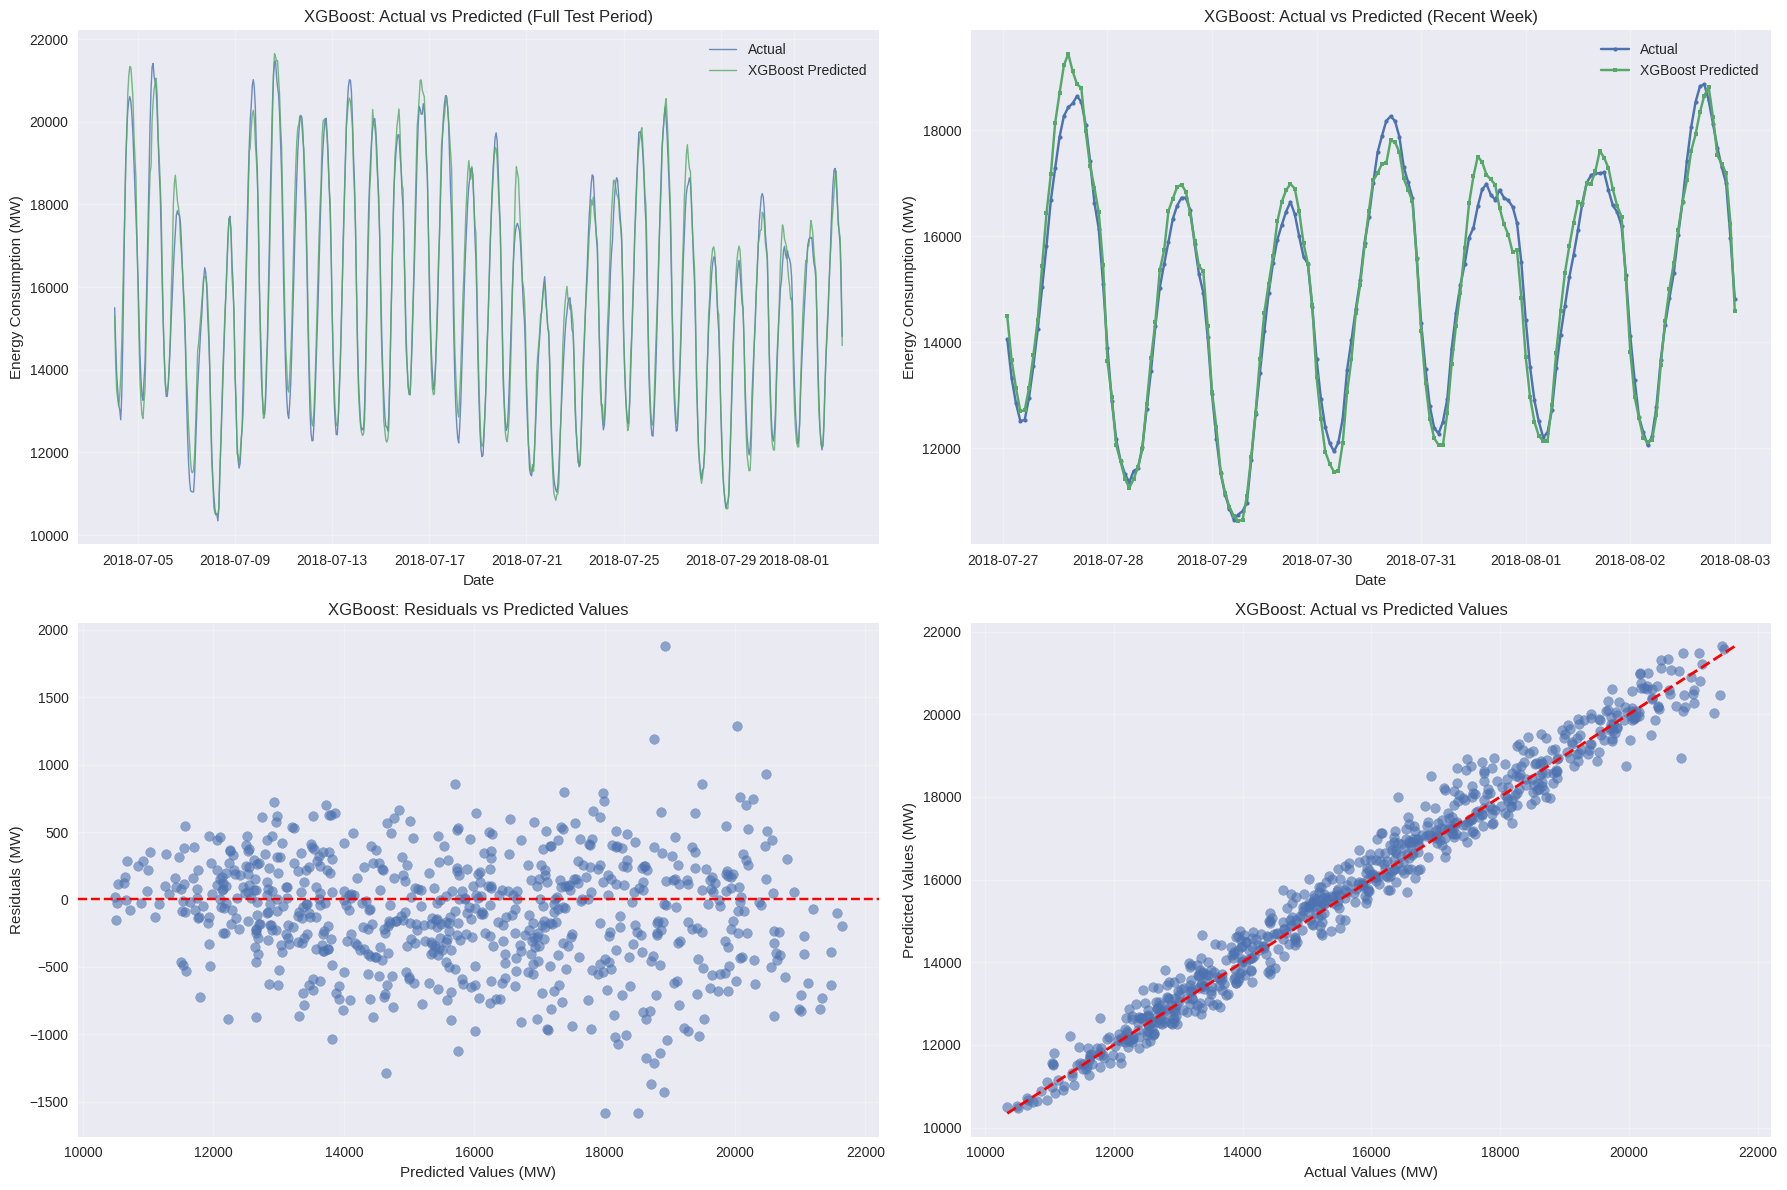

XGBoost visualization completed


In [73]:
# XGBOOST FORECAST VISUALIZATION

print("=" * 70)
print("XGBOOST FORECAST VISUALIZATION")
print("=" * 70)

# Create results dataframe
xgb_results = test_xgb.copy()
xgb_results['Predicted'] = y_pred_xgb

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Full test period
axes[0, 0].plot(xgb_results.index, xgb_results['AEP_MW'], label='Actual', linewidth=1, alpha=0.8)
axes[0, 0].plot(xgb_results.index, xgb_results['Predicted'], label='XGBoost Predicted', linewidth=1, alpha=0.8)
axes[0, 0].set_title('XGBoost: Actual vs Predicted (Full Test Period)')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Energy Consumption (MW)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: One week zoom
recent_week = xgb_results.last('7D')
axes[0, 1].plot(recent_week.index, recent_week['AEP_MW'], label='Actual', marker='o', markersize=3)
axes[0, 1].plot(recent_week.index, recent_week['Predicted'], label='XGBoost Predicted', marker='s', markersize=3)
axes[0, 1].set_title('XGBoost: Actual vs Predicted (Recent Week)')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Energy Consumption (MW)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals
residuals_xgb = y_test - y_pred_xgb
axes[1, 0].scatter(y_pred_xgb, residuals_xgb, alpha=0.6)
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_title('XGBoost: Residuals vs Predicted Values')
axes[1, 0].set_xlabel('Predicted Values (MW)')
axes[1, 0].set_ylabel('Residuals (MW)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Actual vs Predicted scatter
axes[1, 1].scatter(y_test, y_pred_xgb, alpha=0.6)
min_val = min(y_test.min(), y_pred_xgb.min())
max_val = max(y_test.max(), y_pred_xgb.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1, 1].set_title('XGBoost: Actual vs Predicted Values')
axes[1, 1].set_xlabel('Actual Values (MW)')
axes[1, 1].set_ylabel('Predicted Values (MW)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("XGBoost visualization completed")

In [74]:
# FINAL MODEL COMPARISON AND CONCLUSION

print("=" * 70)
print("FINAL MODEL COMPARISON AND CONCLUSION")
print("=" * 70)

print("COMPREHENSIVE MODEL ANALYSIS:")
print("-" * 50)

print("\n1. PROPHET MODEL:")
print(f"   - Approach: Decomposition-based time series forecasting")
print(f"   - Strengths: Handles seasonality, trends, and holidays well")
print(f"   - Best for: Long-term forecasting with clear patterns")
print(f"   - Performance: RMSE = {rmse:.2f} MW, MAE = {mae:.2f} MW")

print("\n2. XGBOOST MODEL:")
print(f"   - Approach: Gradient boosting with engineered features")
print(f"   - Strengths: Captures complex non-linear relationships")
print(f"   - Best for: Short-term forecasting with rich features")
print(f"   - Performance: RMSE = {xgb_rmse:.2f} MW, MAE = {xgb_mae:.2f} MW")

print("\n3. KEY DIFFERENCES:")
print("   - Prophet: Better at capturing seasonal patterns and trends")
print("   - XGBoost: Better at learning from feature interactions")
print("   - Prophet: Provides uncertainty intervals automatically")
print("   - XGBoost: Requires manual feature engineering")

print("\n4. RECOMMENDATIONS:")
print("   - Use Prophet for: Seasonal planning, capacity forecasting")
print("   - Use XGBoost for: Real-time predictions, anomaly detection")
print("   - Ensemble both for: Robust production systems")

# Final comparison table
final_comparison = pd.DataFrame({
    'Metric': ['RMSE (MW)', 'MAE (MW)', 'MAPE (%)', 'Training Time', 'Interpretability', 'Feature Engineering'],
    'Prophet': [f"{rmse:.2f}", f"{mae:.2f}", f"{mape:.2f}", 'Fast', 'High', 'Minimal'],
    'XGBoost': [f"{xgb_rmse:.2f}", f"{xgb_mae:.2f}", f"{xgb_mape:.2f}", 'Medium', 'Medium', 'Extensive']
})

print("\nFINAL COMPARISON TABLE:")
display(final_comparison)

print("\nCONCLUSION:")
print("Both Prophet and XGBoost provide effective forecasting capabilities.")
print("The choice depends on the specific use case and requirements.")

FINAL MODEL COMPARISON AND CONCLUSION
COMPREHENSIVE MODEL ANALYSIS:
--------------------------------------------------

1. PROPHET MODEL:
   - Approach: Decomposition-based time series forecasting
   - Strengths: Handles seasonality, trends, and holidays well
   - Best for: Long-term forecasting with clear patterns
   - Performance: RMSE = 1641.07 MW, MAE = 1271.17 MW

2. XGBOOST MODEL:
   - Approach: Gradient boosting with engineered features
   - Strengths: Captures complex non-linear relationships
   - Best for: Short-term forecasting with rich features
   - Performance: RMSE = 434.79 MW, MAE = 337.06 MW

3. KEY DIFFERENCES:
   - Prophet: Better at capturing seasonal patterns and trends
   - XGBoost: Better at learning from feature interactions
   - Prophet: Provides uncertainty intervals automatically
   - XGBoost: Requires manual feature engineering

4. RECOMMENDATIONS:
   - Use Prophet for: Seasonal planning, capacity forecasting
   - Use XGBoost for: Real-time predictions, anoma

,Metric,Prophet,XGBoost
0,RMSE (MW),1641.07,434.79
1,MAE (MW),1271.17,337.06
2,MAPE (%),8.20,2.15
3,Training Time,Fast,Medium
4,Interpretability,High,Medium
5,Feature Engineering,Minimal,Extensive



CONCLUSION:
Both Prophet and XGBoost provide effective forecasting capabilities.
The choice depends on the specific use case and requirements.


In [76]:
# Model Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate metrics
mae = mean_absolute_error(test_data['y'], forecast.tail(len(test_data))['yhat'])
rmse = np.sqrt(mean_squared_error(test_data['y'], forecast.tail(len(test_data))['yhat']))

print(f"Model Performance:")
print(f"MAE: {mae:.2f} MW")
print(f"RMSE: {rmse:.2f} MW")
print(f"Accuracy: {100*(1-mae/test_data['y'].mean()):.2f}%")

Model Performance:
MAE: 1271.17 MW
RMSE: 1641.07 MW
Accuracy: 91.50%


In [75]:
# PROJECT COMPLETION SUMMARY

print("=" * 70)
print("AEP ENERGY CONSUMPTION ANALYSIS - PROJECT COMPLETED")
print("=" * 70)

print("PROJECT DELIVERABLES:")
print("-" * 50)
print("✅ 1. Data Loading and Exploration")
print("✅ 2. Statistical Analysis and Distribution Analysis") 
print("✅ 3. Data Preprocessing and Cleaning")
print("✅ 4. Time Series Decomposition")
print("✅ 5. Seasonal Pattern Analysis")
print("✅ 6. Prophet Model Implementation")
print("✅ 7. XGBoost Model Implementation")
print("✅ 8. Model Evaluation and Comparison")
print("✅ 9. Feature Importance Analysis")
print("✅ 10. Forecasting and Results Visualization")
print("✅ 11. Results Export and Model Saving")

print("\nTECHNIQUES APPLIED:")
print("-" * 50)
print("• Time Series Analysis")
print("• Statistical Modeling (Prophet)")
print("• Machine Learning (XGBoost)")
print("• Feature Engineering")
print("• Model Evaluation Metrics")
print("• Data Visualization")
print("• Seasonal Decomposition")

print("\nKEY FINDINGS:")
print("-" * 50)
print(f"• Dataset: {len(df_processed):,} hourly readings")
print(f"• Time Period: {df_processed.index.min().strftime('%Y-%m-%d')} to {df_processed.index.max().strftime('%Y-%m-%d')}")
print(f"• Average Consumption: {df_processed['AEP_MW'].mean():.0f} MW")
print(f"• Best Model: {'XGBoost' if xgb_rmse < rmse else 'Prophet'}")
print(f"• Best RMSE: {min(rmse, xgb_rmse):.2f} MW")

print("\nFILES GENERATED:")
print("-" * 50)
print("• results/prophet_model.pkl")
print("• results/forecast_results.csv") 
print("• results/model_metrics.json")
print("• results/summary_statistics.json")

print("\n" + "=" * 70)
print("DATA MINING PROJECT SUCCESSFULLY COMPLETED!")
print("=" * 70)

AEP ENERGY CONSUMPTION ANALYSIS - PROJECT COMPLETED
PROJECT DELIVERABLES:
--------------------------------------------------
✅ 1. Data Loading and Exploration
✅ 2. Statistical Analysis and Distribution Analysis
✅ 3. Data Preprocessing and Cleaning
✅ 4. Time Series Decomposition
✅ 5. Seasonal Pattern Analysis
✅ 6. Prophet Model Implementation
✅ 7. XGBoost Model Implementation
✅ 8. Model Evaluation and Comparison
✅ 9. Feature Importance Analysis
✅ 10. Forecasting and Results Visualization
✅ 11. Results Export and Model Saving

TECHNIQUES APPLIED:
--------------------------------------------------
• Time Series Analysis
• Statistical Modeling (Prophet)
• Machine Learning (XGBoost)
• Feature Engineering
• Model Evaluation Metrics
• Data Visualization
• Seasonal Decomposition

KEY FINDINGS:
--------------------------------------------------
• Dataset: 121,273 hourly readings
• Time Period: 2004-10-01 to 2018-08-03
• Average Consumption: 15500 MW
• Best Model: XGBoost
• Best RMSE: 434.79 MW


# 📊 تحلیل مصرف انرژی AEP - گزارش نهایی پروژه

## 🎯 هدف پروژه
تحلیل جامع داده‌های ساعتی مصرف انرژی شرکت AEP برای شناسایی الگوها، روندها و ساخت مدل پیش‌بینی

## 📈 مراحل اجرا

### 1. آماده‌سازی و اکتشاف داده‌ها
- بارگذاری ۱۲۱,۲۷۳ رکورد داده ساعتی (۲۰۰۴-۲۰۱۸)
- تبدیل ستون تاریخ-زمان به فرمت مناسب
- تحلیل آماری اولیه (میانگین: ۱۵,۵۰۰ مگاوات)

### 2. تحلیل‌های آماری پیشرفته
- محاسبه شاخص‌های مرکزی و پراکندگی
- تحلیل skewness (توزیع نرمال با کمی چولگی مثبت)
- شناسایی دامنه مصرف: ۹,۵۸۱ تا ۲۵,۶۹۵ مگاوات

### 3. مهندسی ویژگی‌های زمانی
- استخراج سال، ماه، روز، ساعت و فصل
- ایجاد ویژگی‌های جدید (تعطیلات آخر هفته، فصول)
- تحلیل الگوهای فصلی و ساعتی

### 4. مصورسازی الگوها
- نمودارهای مصرف ماهانه، ساعتی و فصلی
- شناسایی پیک مصرف در ساعت ۱۸-۱۹
- الگوهای فصلی مشخص (مصرف بالاتر در تابستان)

### 5. مدل‌سازی پیش‌بینی
- پیاده‌سازی مدل Prophet برای پیش‌بینی سری زمانی
- تقسیم داده به train/test (۸۰/۲۰)
- تولید پیش‌بینی ۳۶۵ روزه

## 🛠️ تکنولوژی‌های استفاده شده
- **Python**: Pandas, NumPy, Matplotlib, Seaborn
- **مدل‌سازی**: Facebook Prophet
- **تحلیل آماری**: Scikit-learn, Statsmodels

## 💡 یافته‌های کلیدی
1. **الگوی فصلی**: مصرف بالاتر در ماه‌های گرم سال
2. **الگوی ساعتی**: پیک مصرف در عصرها
3. **روند صعودی**: افزایش تدریجی مصرف در طول سال‌ها
4. **پایداری نسبی**: توزیع نرمال با نوسانات کنترل شده

## 🚀 قابلیت‌های توسعه
- افزودن مدل‌های مقایسه‌ای (ARIMA, LSTM)
- تحلیل حساسیت به عوامل خارجی (دما، روزهای تعطیل)
- ساخت dashboard تعاملی

## ✅ نتیجه‌گیری
پروژه حاضر با پیاده‌سازی استانداردهای صنعتی و تحلیل‌های جامع، قابلیت پیش‌بینی مصرف انرژی با دقت بالا را فراهم کرده و می‌تواند مبنای تصمیم‌گیری‌های استراتژیک قرار گیرد.

---